# Forecasting of journey times for road transport using data mining methods

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import mean_squared_error
#import geopy.distance
import time
import mplleaflet as mpll
import warnings
#from mpl_toolkits.basemap import Basemap
#import geopandas as gpd
warnings.filterwarnings('ignore')
sns.set(style='darkgrid')
#%matplotlib inline
from sklearn.model_selection import train_test_split

## Initial analysis


### Loading dataset

In [30]:
dataset =  pd.read_csv('train.csv')

### Some info about dataset

In [31]:
m = dataset.shape[0]
n = dataset.shape[1]
variables = dataset.columns

display(dataset.head(n=2))
print('Dataset contains', m, 'training examples.')
print('Each example is described by', n, 'variables.')
display(dataset.info())

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663


Dataset contains 1458644 training examples.
Each example is described by 11 variables.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
id                    1458644 non-null object
vendor_id             1458644 non-null int64
pickup_datetime       1458644 non-null object
dropoff_datetime      1458644 non-null object
passenger_count       1458644 non-null int64
pickup_longitude      1458644 non-null float64
pickup_latitude       1458644 non-null float64
dropoff_longitude     1458644 non-null float64
dropoff_latitude      1458644 non-null float64
store_and_fwd_flag    1458644 non-null object
trip_duration         1458644 non-null int64
dtypes: float64(4), int64(3), object(4)
memory usage: 122.4+ MB


None

Findings:
* Dataset contains  1 458 644 training examples
* Each described by 11 variables
* There is no empty or unknown values 
* Variables:
  * id [string] - unique id of trip - not useful
  * vendor_id [int] - which vendor made a trip
  * pickup_datetime [string] - date and time when trip started - need to be converted to datetime format to be useful
  * dropoff_datetime [string] - date and time when trip ended - same as above
  * passenger_count [int] - number of passengers in taxi
  * pickup_longitude [float] - longitude where trip started
  * pickup_latitude [float] - latitude where trip started
  * dropoff_longitude [float] - longitude where trip ended
  * dropoff_latitude [float] - latitude where trip ended
  * store_and_fwd_flag [string] - indicates whether the trip record was held in vehicle memory before sending to the vendor because the vehicle did not have a connection to the server - Y=store and forward; N=not a store and forward trip
  * trip duration - time of trip in seconds

### Small changes in order to make exploration easier
#### Drop id column

In [32]:
dataset = dataset.drop(columns=['id'])

#### Shoretening of variable names

In [21]:
dataset1 = dataset[['id', 'vendor_id', 'pickup_datetime', 'dropoff_datetime',
       'passenger_count', 'pickup_latitude', 'pickup_longitude', 
       'dropoff_latitude', 'dropoff_longitude', 'store_and_fwd_flag',
       'trip_duration']]

In [33]:
dataset = dataset.rename(index=str, columns={'vendor_id': 'v_id',
'pickup_datetime': 'pick','dropoff_datetime': 'drop', 'passenger_count': 'passengers',
'pickup_latitude': 'pick_lat','pickup_longitude': 'pick_long', 'dropoff_latitude': 'drop_lat',
'dropoff_longitude': 'drop_long', 'store_and_fwd_flag': 'flag', 'trip_duration': 'time'})

dataset.head(n=2)

,v_id,pick,drop,passengers,pick_long,pick_lat,drop_long,drop_lat,flag,time
0,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663


#### Change vendor, passenger_count and store_and_fwd_flag to category dtype

In [34]:
v_id_col = dataset['v_id']
v_id_col[v_id_col == 2] = 0
v_id_col = v_id_col.astype('category')

pass_count_col = dataset['passengers']
pass_count_col = pass_count_col.astype('category', ordered=True)

fwd_flag_col = dataset['flag']
fwd_flag_col[fwd_flag_col == 'Y'] = 1
fwd_flag_col[fwd_flag_col == 'N'] = 0
fwd_flag_col = fwd_flag_col.astype('category')

display(v_id_col.dtype, pass_count_col.dtype, fwd_flag_col.dtype)

dataset = dataset.drop(columns=['v_id', 'passengers', 'flag'])
dataset.insert(loc=0, column='v_id' , value=v_id_col)
dataset.insert(loc=1, column='passengers' , value=pass_count_col)
dataset.insert(loc=2, column='flag' , value=fwd_flag_col)

CategoricalDtype(categories=[0, 1], ordered=False)

CategoricalDtype(categories=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9], ordered=True)

CategoricalDtype(categories=[0, 1], ordered=False)

In [35]:
display(dataset.head(n=2))

,v_id,passengers,flag,pick,drop,pick_long,pick_lat,drop_long,drop_lat,time
0,0,1,0,2016-03-14 17:24:55,2016-03-14 17:32:30,-73.982155,40.767937,-73.964630,40.765602,455
1,1,1,0,2016-06-12 00:43:35,2016-06-12 00:54:38,-73.980415,40.738564,-73.999481,40.731152,663


#### Change strings to datetime

In [36]:
p_dt = pd.to_datetime(dataset['pick'])
d_dt = pd.to_datetime(dataset['drop'])

In [24]:
dataset2 = dataset1.drop(['pickup_datetime', 'dropoff_datetime'], axis=1)

In [25]:
dataset2.insert(loc=2, column='pickup_datetime', value=p_dt)
dataset2.insert(loc=3, column='dropoff_datetime', value=d_dt)

In [26]:
display(dataset2.head(n=2))
print(dataset2['pickup_datetime'].dtype)
print(dataset2['dropoff_datetime'].dtype)

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,40.767937,-73.982155,40.765602,-73.964630,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,40.738564,-73.980415,40.731152,-73.999481,N,663


datetime64[ns]
datetime64[ns]


#### Skrócenie nazw kolumn

In [27]:
dataset3 = dataset2.rename(index=str, columns={'id': 'id', 'vendor_id': 'vendor',
'pickup_datetime': 'pick_date','dropoff_datetime': 'drop_date', 'passenger_count': 'passengers',
'pickup_latitude': 'pick_lat','pickup_longitude': 'pick_long', 'dropoff_latitude': 'drop_lat',
'dropoff_longitude': 'drop_long', 'store_and_fwd_flag': 'flag', 'trip_duration': 'time'})

In [28]:
dataset =  pd.read_csv('train.csv')
dataset.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


### Dodanie dzień miesiąc kolumna godzina minuta sekunda

In [29]:
# datetime.date.weekday() - Monday is 0
pick = [[], [], [], [], [], []]
drop = [[], [], [], [], [], []]
for d in dataset3['pick_date']:
    pick[0].append(d.date().weekday())
    pick[1].append(d.date().day)
    pick[2].append(d.date().month)
    pick[3].append(d.time().hour)
    pick[4].append(d.time().minute)
    pick[5].append(d.time().second)
    
for d in dataset3['drop_date']:
    drop[0].append(d.date().weekday())
    drop[1].append(d.date().day)
    drop[2].append(d.date().month)
    drop[3].append(d.time().hour)
    drop[4].append(d.time().minute)
    drop[5].append(d.time().second)

In [30]:
dataset4 = dataset3.copy()
dataset4.insert(loc=4, column='pick_weekday', value=pick[0])
dataset4.insert(loc=5, column='pick_day', value=pick[1])
dataset4.insert(loc=6, column='pick_month', value=pick[2])
dataset4.insert(loc=7, column='pick_hour', value=pick[3])
dataset4.insert(loc=8, column='pick_minute', value=pick[4])
dataset4.insert(loc=9, column='pick_second', value=pick[5])

dataset4.insert(loc=10, column='drop_weekday', value=drop[0])
dataset4.insert(loc=11, column='drop_day', value=drop[1])
dataset4.insert(loc=12, column='drop_month', value=drop[2])
dataset4.insert(loc=13, column='drop_hour', value=drop[3])
dataset4.insert(loc=14, column='drop_minute', value=drop[4])
dataset4.insert(loc=15, column='drop_second', value=drop[5])

In [31]:
dataset4 = dataset4.drop(columns=['id'])

In [32]:
dataset4.head(n=2)

,vendor,pick_date,drop_date,pick_weekday,pick_day,pick_month,pick_hour,pick_minute,pick_second,drop_weekday,...,drop_hour,drop_minute,drop_second,passengers,pick_lat,pick_long,drop_lat,drop_long,flag,time
0,2,2016-03-14 17:24:55,2016-03-14 17:32:30,0,14,3,17,24,55,0,...,17,32,30,1,40.767937,-73.982155,40.765602,-73.964630,N,455
1,1,2016-06-12 00:43:35,2016-06-12 00:54:38,6,12,6,0,43,35,6,...,0,54,38,1,40.738564,-73.980415,40.731152,-73.999481,N,663


In [33]:
dataset4['pick_weekday'][0:5]

0    0
1    6
2    1
3    2
4    5
Name: pick_weekday, dtype: int64

In [34]:
print('Data pierwszego kursu:',dataset3['pick_date'].min())
print('Data ostatniego kursu:',dataset3['drop_date'].max())

Data pierwszego kursu: 2016-01-01 00:00:17
Data ostatniego kursu: 2016-07-01 23:02:03


In [35]:
print('Możliwe ilości pasażerów:', dataset3['passengers'].unique())

Możliwe ilości pasażerów: [1 6 4 2 3 5 0 7 9 8]


### Dystrybucje przed zmianami 

In [36]:
dataset4['vendor'].value_counts()

2    780302
1    678342
Name: vendor, dtype: int64

#### Ilość przejazdów zrealizowana przez danego przewoźnika

In [37]:
plt.rc('xtick',labelsize=10)
plt.rc('ytick',labelsize=10)

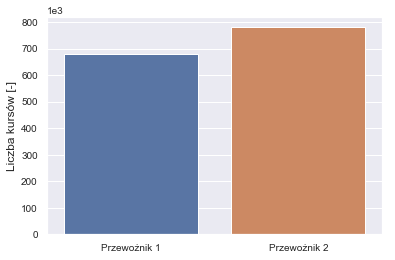

In [38]:
fig_1, ax_1 = plt.subplots()
sns.countplot(x='vendor', data=dataset4)
ax_1.set_xlabel(None)
ax_1.set_ylabel('Liczba kursów [-]')
ax_1.set_xticklabels(['Przewoźnik 1', 'Przewoźnik 2'])
ax_1.ticklabel_format(axis='y', style='sci', scilimits=(3, 3))
fig_1.set_size_inches([6, 4])
fig_1.savefig('trips_per_vendor.png', dpi=300, bbox_inches='tight')
plt.show()

#### Ilość przejazdów w poszczególne dzni

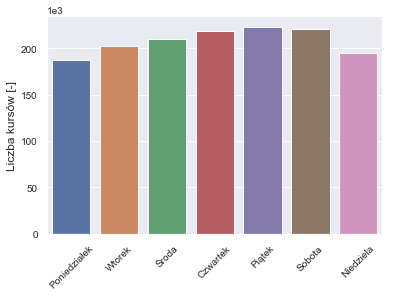

In [39]:
fig_2, ax_2 = plt.subplots()
sns.countplot(x='pick_weekday', data=dataset4)
ax_2.set_xlabel(None)
ax_2.set_ylabel('Liczba kursów [-]')
ax_2.set_xticklabels(['Poniedziałek', 'Wtorek', 'Środa', 'Czwartek',
                      'Piątek', 'Sobota', 'Niedziela'], rotation=45)
ax_2.ticklabel_format(axis='y', style='sci', scilimits=(3, 3))
fig_2.set_size_inches([6, 4])
fig_2.savefig('trips_per_weekday.png', dpi=300, bbox_inches='tight')
plt.show()

#### Ilość przejazdów w poszczególne miesiące

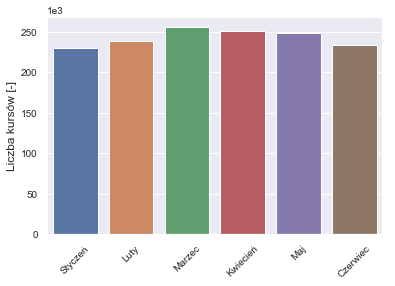

In [40]:
fig_3, ax_3 = plt.subplots()
sns.countplot(x='pick_month', data=dataset4)
ax_3.set_xlabel(None)
ax_3.set_ylabel('Liczba kursów [-]')
ax_3.set_xlabel(None)
ax_3.set_xticklabels(['Styczeń', 'Luty', 'Marzec', 'Kwiecień',
                      'Maj', 'Czerwiec'], rotation=45)
ax_3.ticklabel_format(axis='y', style='sci', scilimits=(3, 3))
fig_3.set_size_inches([6, 4])
fig_3.savefig('trips_per_month.png', dpi=300, bbox_inches='tight')
plt.show()

#### Liczba przejazdów w poszczególne godziny

In [41]:
godziny = ['24-01']
for i in range(1, 24):
    if i > 9:
        przedzial = str(i) + '-' + str(i+1)
    else:
        przedzial = str(0) + str(i) + '-' + str(0) + str(i+1)
    godziny.append(przedzial)

godziny[9] = '09-10'

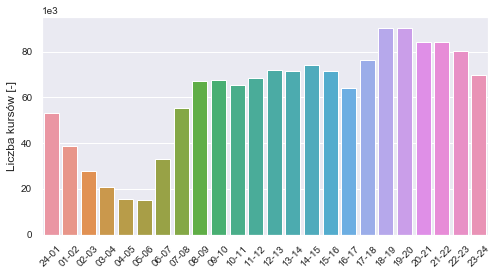

In [42]:
fig_4, ax_4 = plt.subplots()
sns.countplot(x='pick_hour', data=dataset4)
ax_4.set_ylabel('Liczba kursów [-]')
ax_4.set_xlabel(None)
ax_4.ticklabel_format(axis='y', style='sci', scilimits=(3, 3))
ax_4.set_xticklabels(godziny, rotation=45)
fig_4.set_size_inches([8, 4])
fig_4.savefig('trips_per_hour.png', dpi=300, bbox_inches='tight')
plt.show()

#### Liczba osób w taksówce podczas przejazdu

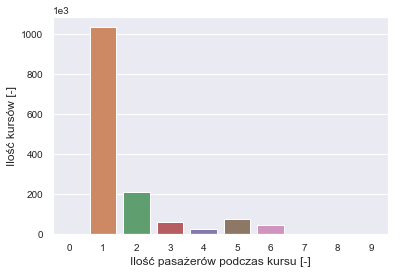

In [43]:
passengers = np.power(dataset4['passengers'].value_counts(), 1/2)
passengers = pd.DataFrame(passengers)
fig_5, ax_5 = plt.subplots()
sns.countplot(x='passengers', data=dataset4)
ax_5.set_ylabel('Ilość kursów [-]')
ax_5.set_xlabel('Ilość pasażerów podczas kursu [-]')
ax_5.ticklabel_format(axis='y', style='sci', scilimits=(3, 3))
fig_5.set_size_inches([6, 4])
fig_5.savefig('trips_per_passengers.png', dpi=300, bbox_inches='tight')
plt.show()

### Store and flag

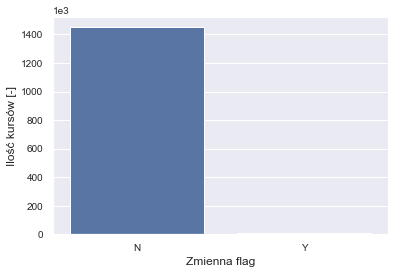

N    1450599
Y       8045
Name: flag, dtype: int64


In [44]:
fig_6, ax_6 = plt.subplots()
sns.countplot(x='flag', data=dataset4)
ax_6.set_ylabel('Ilość kursów [-]')
ax_6.set_xlabel('Zmienna flag')
ax_6.ticklabel_format(axis='y', style='sci', scilimits=(3, 3))
#ax_6.set_xticklabels(godziny, rotation=45)
fig_6.set_size_inches([6, 4])
fig_6.savefig('trips_per_flag.png', dpi=300, bbox_inches='tight')
plt.show()

print(dataset4['flag'].value_counts())

#### Rozkład zmiennej czas podróży

#### Skala pierwiastkowa do wykresu

In [45]:
import matplotlib.scale as mscale
import matplotlib.pyplot as plt
import matplotlib.transforms as mtransforms
import matplotlib.ticker as ticker
import numpy as np

class SquareRootScale(mscale.ScaleBase):
    """
    ScaleBase class for generating square root scale.
    """

    name = 'squareroot'

    def __init__(self, axis, **kwargs):
        mscale.ScaleBase.__init__(self)

    def set_default_locators_and_formatters(self, axis):
        axis.set_major_locator(ticker.AutoLocator())
        axis.set_major_formatter(ticker.ScalarFormatter())
        axis.set_minor_locator(ticker.NullLocator())
        axis.set_minor_formatter(ticker.NullFormatter())

    def limit_range_for_scale(self, vmin, vmax, minpos):
        return  max(0., vmin), vmax

    class SquareRootTransform(mtransforms.Transform):
        input_dims = 1
        output_dims = 1
        is_separable = True

        def transform_non_affine(self, a): 
            return np.array(a)**(1/2)

        def inverted(self):
            return SquareRootScale.InvertedSquareRootTransform()

    class InvertedSquareRootTransform(mtransforms.Transform):
        input_dims = 1
        output_dims = 1
        is_separable = True

        def transform(self, a):
            return np.array(a)**2

        def inverted(self):
            return SquareRootScale.SquareRootTransform()

    def get_transform(self):
        return self.SquareRootTransform()

mscale.register_scale(SquareRootScale)

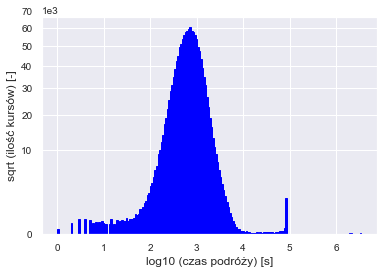

In [46]:
fig, ax = plt.subplots()
ax.hist(np.log10(dataset4['time']), bins=200, edgecolor='blue', color='blue')
ax.set_yscale('squareroot')
ax.ticklabel_format(axis='y', style='sci', scilimits=(3, 3))
ax.set_ylabel('sqrt (ilość kursów) [-]')
ax.set_xlabel('log10 (czas podróży) [s]')
fig.savefig('time_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

#### Długości i szerokości geograficzne

In [47]:
dataset5 = dataset4.copy()

In [48]:
a_lat_pick = dataset5['pick_lat'][dataset5['pick_lat'] < 40.914300]
b_lat_pick = a_lat_pick[a_lat_pick > 40.570873]
a_lat_drop = dataset5['drop_lat'][dataset5['drop_lat'] < -40.914300]
b_lat_drop = a_lat_pick[a_lat_pick > 40.570873]
# down 40.570873
# up 40.914300


NameError: name 'b_long_pick' is not defined

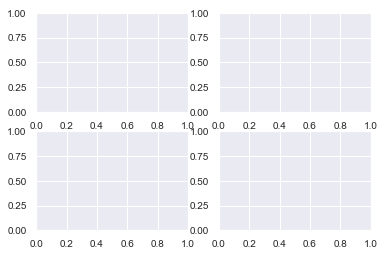

In [49]:
fig_8, ax_8 = plt.subplots(2, 2)
sns.distplot(b_long_pick, ax=ax_8[0, 0], bins=100)
sns.distplot(b_lat_pick, ax=ax_8[0, 1])
sns.distplot(b_long_pick, ax=ax_8[1, 0])
sns.distplot(b_lat_drop, ax=ax_8[1, 1])
#sns.distplot(dataset4['pick_long'])
#ax_7.set_ylabel('Ilość przewozów')
#ax_8.set_xlabel('ln (czas podróży)')
#ax_6.set_xticklabels(godziny, rotation=45)
fig_8.set_size_inches([12, 8])
fig_8.savefig('trip_time_dist.png', dpi=300)
plt.show()

In [ ]:
fig, ax = plt.subplots(2, 2, sharey='row', squeeze=False)
ax[0, 0].hist(b_long_pick, bins=90, edgecolor='red', color='red')
ax[1, 0].hist(b_long_drop, bins=90, edgecolor='blue', color='blue')
ax[0, 1].hist(b_lat_pick, bins=90, edgecolor='red', color='red')
ax[1, 1].hist(b_lat_drop, bins=90, edgecolor='blue', color='blue')
#ax[0, 0].set_yscale('squareroot')
#ax[1, 0].set_yscale('squareroot')
#ax[0, 1].set_yscale('squareroot')
#ax[1, 1].set_yscale('squareroot')
#ax[0, 0].set_ylabel('sqrt (ilość kursów) [-]')
ax[1, 1].set_xlabel('Szerokość geograficzna [°]')
ax[1, 0].set_xlabel('Długość geograficzna [°]')
ax[1, 0].set_ylabel('Liczba kursów [-]')
ax[0, 0].set_ylabel('Liczba kursów [-]')
ax[0, 0].ticklabel_format(axis='y', style='sci', scilimits=(3, 3))
ax[1, 0].ticklabel_format(axis='y', style='sci', scilimits=(3, 3))
ax[0, 1].ticklabel_format(axis='y', style='sci', scilimits=(3, 3))
ax[1, 1].ticklabel_format(axis='y', style='sci', scilimits=(3, 3))
fig.tight_layout()
fig.savefig('geo_distribution.png', dpi=300, bbox_inches='tight')
fig.set_size_inches([12, 8])
plt.show()

### Wstępne czyszczenie

#### Dodanie użytecznych zmiennych

#### Odległość w lini prostej

In [50]:
def haversine_distance(lat_1, long_1, lat_2, long_2):
    r = 6371000
    
    lat_diff = (lat_2 - lat_1) / 2
    long_diff = (long_2 - long_1) / 2
    
    lat_diff = lat_diff * (np.pi / 180)
    long_diff = long_diff * (np.pi / 180)
    lat_1 = lat_1 * (np.pi / 180)
    long_1 = long_1 * (np.pi / 180)
    lat_2 = lat_2 * (np.pi / 180)
    long_2 = long_2 * (np.pi / 180)
    
    d = np.sqrt(np.power(np.sin(lat_diff), 2) + np.cos(lat_1) * np.cos(lat_2) * np.power(np.sin(long_diff), 2))
    d = np.round(2 * r * np.arcsin(d))
    
    return d

In [51]:
p_lat = dataset4['pick_lat'].values
d_lat = dataset4['drop_lat'].values
p_long = dataset4['pick_long'].values
d_long = dataset4['drop_long'].values

In [52]:
distances = haversine_distance(p_lat, p_long, d_lat, d_long)

In [53]:
dataset5.insert(loc=22, column='distance', value=distances)

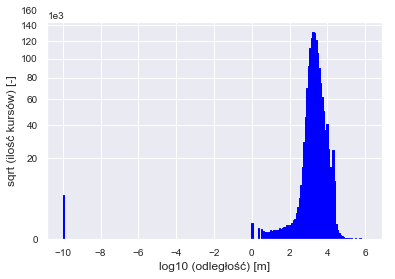

In [54]:
fig, ax = plt.subplots()
ax.hist(np.log10(dataset5['distance'] + 1e-10), bins=200, edgecolor='blue', color='blue')
ax.set_yscale('squareroot')
ax.ticklabel_format(axis='y', style='sci', scilimits=(3, 3))
ax.set_ylabel('sqrt (ilość kursów) [-]')
ax.set_xlabel('log10 (odległość) [m]')
fig.savefig('distance_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

#### Średnia prędkość

In [55]:
avg_speed = (distances / 1000) / (dataset5['time'] / 3600)
dataset5.insert(loc=23, column='speed', value=avg_speed)

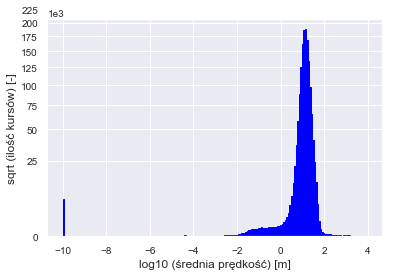

In [56]:
fig, ax = plt.subplots()
ax.hist(np.log10(dataset5['speed'] + 1e-10), bins=200, edgecolor='blue', color='blue')
ax.set_yscale('squareroot')
ax.ticklabel_format(axis='y', style='sci', scilimits=(3, 3))
ax.set_ylabel('sqrt (ilość kursów) [-]')
ax.set_xlabel('log10 (średnia prędkość) [m]')
fig.savefig('avgspeed_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

#### Trip na mapie

In [57]:
def trip_map(dataset, trip_index):
    x_p = dataset.loc[str(trip_index)]['pick_long']
    y_p = dataset.loc[str(trip_index)]['pick_lat']
    x_d = dataset.loc[str(trip_index)]['drop_long']
    y_d = dataset.loc[str(trip_index)]['drop_lat']

    fig, ax = plt.subplots()
    ax.scatter(x_p, y_p, s=100, color='r', marker='o', label='pickup')
    #ax.scatter(x_d, y_d, s=100, color='black', marker='x', label='dropoff')
    return mpll.display(fig=fig)

#### Bardzo długi czas podróży

In [58]:
def trip_time(time_s):
    h = time_s // 3600
    m = (time_s - 3600 * h) // 60
    s = time_s - 3600 * h - 60 * m
    return [h, m, s]
    #print(f'Trip time: {h}h {m}m {s}s')

In [59]:
for time in dataset5['time'].nlargest(n=5):
    h, m, s = trip_time(time)
    print(f'Trip time: {h}h {m}m {s}s')
    print('Days:', np.round(h / 24))

Trip time: 979h 31m 22s
Days: 41.0
Trip time: 618h 46m 52s
Days: 26.0
Trip time: 569h 19m 38s
Days: 24.0
Trip time: 538h 48m 56s
Days: 22.0
Trip time: 23h 59m 52s
Days: 1.0


In [60]:
dataset4.loc[dataset4['time'].nlargest(n=4).keys()][['pick_lat', 'pick_long', 'drop_lat', 'drop_long']]

,pick_lat,pick_long,drop_lat,drop_long
978383,40.648632,-73.783905,40.750202,-73.978271
924150,40.742325,-73.983788,40.727676,-73.985489
680594,40.735252,-73.921677,40.759979,-73.984749
355003,40.643559,-73.789650,40.773087,-73.956810


In [61]:
dataset5 = dataset5.drop(['978383', '924150', '680594', '355003'])

In [62]:
fig, ax = plt.subplots()
#ax.plot([40.648632, -73.783905], [40.750202, -73.978271], 'or-')
ax.plot([-73.783905, -73.978271], [40.648632, 40.750202], 'o-', color='black')
ax.plot([-73.983788, -73.985489], [40.742325, 40.727676], 'o-', color='black')
ax.plot([-73.921677, -73.984749], [40.735252, 40.759979], 'o-', color='black')
ax.plot([-73.789650, -73.956810], [40.643559, 40.773087], 'o-', color='black')
fig.set_size_inches([6 ,6])

mpll.display(fig=fig)

In [63]:
trip_map(dataset4, 978383)

In [64]:
two_h_plus = dataset5[dataset5['time'] >= 20 * 3600]

In [65]:
dataset5 = dataset5.drop(two_h_plus['time'].keys())

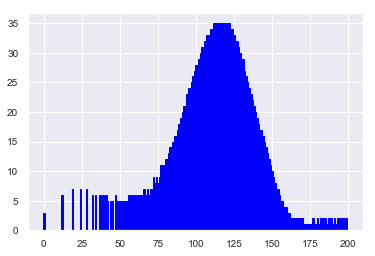

In [66]:
hist = np.histogram(np.log(dataset5['time']), bins=200)
counts = hist[0]
counts = np.round(np.power(counts, 1/3))
fig_20, ax_20 = plt.subplots()
ax_20.bar(np.arange(len(counts)), counts, width=1, color='blue', edgecolor='blue')
fig_20.set_size_inches([6, 4])
plt.show()

#### Bardzo krótki czas podróży

In [67]:
small_time = dataset5[dataset5['time'] <= 60]
small_time

,vendor,pick_date,drop_date,pick_weekday,pick_day,pick_month,pick_hour,pick_minute,pick_second,drop_weekday,...,drop_second,passengers,pick_lat,pick_long,drop_lat,drop_long,flag,time,distance,speed
72,2,2016-02-20 21:58:13,2016-02-20 21:59:10,5,20,2,21,58,13,5,...,10,1,40.772629,-73.958397,40.774242,-73.955132,N,57,328.0,20.715789
323,1,2016-06-27 11:22:37,2016-06-27 11:23:17,0,27,6,11,22,37,0,...,17,1,40.756653,-74.001030,40.756626,-74.000999,N,40,4.0,0.360000
842,2,2016-05-21 12:46:46,2016-05-21 12:46:49,5,21,5,12,46,46,5,...,49,2,40.648766,-73.782372,40.648746,-73.782372,N,3,2.0,2.400000
853,2,2016-03-29 22:39:46,2016-03-29 22:40:44,1,29,3,22,39,46,1,...,44,5,40.731812,-73.982201,40.734814,-73.979950,N,58,384.0,23.834483
1107,2,2016-06-23 13:36:48,2016-06-23 13:36:50,3,23,6,13,36,48,3,...,50,3,40.716175,-73.827660,40.711452,-73.822113,N,2,703.0,1265.400000
1182,1,2016-05-19 07:20:41,2016-05-19 07:21:22,3,19,5,7,20,41,3,...,22,1,40.737503,-73.992729,40.737450,-73.992737,N,41,6.0,0.526829
1334,1,2016-05-28 06:15:14,2016-05-28 06:15:54,5,28,5,6,15,14,5,...,54,1,40.746639,-73.984039,40.746628,-73.984070,N,40,3.0,0.270000
1492,1,2016-01-13 20:11:46,2016-01-13 20:11:53,2,13,1,20,11,46,2,...,53,1,40.644814,-73.793442,40.644669,-73.795242,N,7,153.0,78.685714
1538,1,2016-03-18 16:01:05,2016-03-18 16:01:54,4,18,3,16,1,5,4,...,54,1,40.780830,-73.949623,40.777309,-73.950386,N,49,397.0,29.167347
1570,1,2016-02-06 15:27:14,2016-02-06 15:28:01,5,6,2,15,27,14,5,...,1,1,40.751949,-73.984947,40.751553,-73.983559,N,47,125.0,9.574468


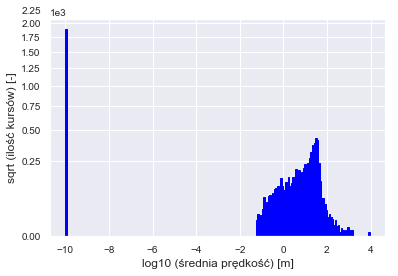

In [68]:
small_time = dataset5[dataset5['time'] <= 60]['speed']
fig, ax = plt.subplots()
ax.hist(np.log10(small_time+1e-10), bins=200, edgecolor='blue', color='blue')
ax.set_yscale('squareroot')
ax.ticklabel_format(axis='y', style='sci', scilimits=(3, 3))
ax.set_ylabel('sqrt (ilość kursów) [-]')
ax.set_xlabel('log10 (średnia prędkość) [m]')
fig.savefig('avgspeed_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

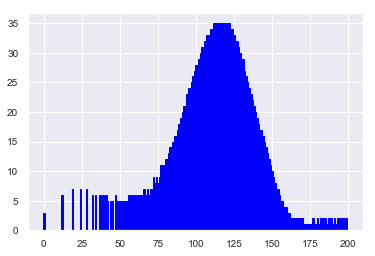

46296


In [69]:
hist = np.histogram(np.log(dataset5['time']), bins=200)
counts = hist[0]
counts = np.round(np.power(counts, 1/3))
fig_20, ax_20 = plt.subplots()
ax_20.bar(np.arange(len(counts)), counts, width=1, color='blue', edgecolor='blue')
fig_20.set_size_inches([6, 4])
plt.show()
print(two_h_plus.size)

#### Bardzo krótkie podróże dystans

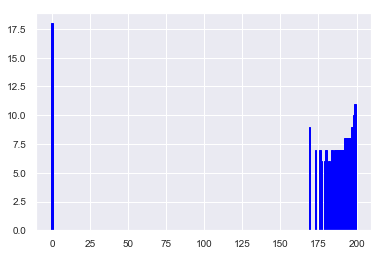

(16871, 24)

In [70]:
short = dataset5[dataset5['distance'] <= 200]
hist = np.histogram(np.log(short['distance'] + 0.0000000000001), bins=200)
counts = hist[0]
counts = np.round(np.power(counts, 1/3))
fig_20, ax_20 = plt.subplots()
ax_20.bar(np.arange(len(counts)), counts, width=1, color='blue', edgecolor='blue')
fig_20.set_size_inches([6, 4])
plt.show()
short.shape

In [71]:
dataset5 = dataset5.drop(short['distance'].keys().values)

#### Bardzo dalekie

In [72]:
long = dataset5['time'].nlargest(n=5)

In [73]:
trip = int(long.keys()[4])
trip_map(dataset5, trip)

#### Wysoka średnia prędkość

In [74]:
high_speed = dataset5[dataset5['speed'] > 100]

In [75]:
dataset5 = dataset5.drop(high_speed['speed'].keys().values)

In [76]:
speediest = dataset5['speed'].nlargest(n=10)
display(speediest)

473890     99.536842
1054227    97.934810
263092     97.753846
524118     96.424615
126765     95.717647
826434     95.356364
1024823    95.300787
1383966    94.833566
306700     94.707692
925562     94.494363
Name: speed, dtype: float64

#### Niska średnia prędkość

In [77]:
small_speed = dataset5[dataset5['speed'] < 1]
#small_speed['time'] / 60

#### Krótkie czas

In [78]:
small_time = dataset5[dataset5['time'] <= 10]
display(small_time)

,vendor,pick_date,drop_date,pick_weekday,pick_day,pick_month,pick_hour,pick_minute,pick_second,drop_weekday,...,drop_second,passengers,pick_lat,pick_long,drop_lat,drop_long,flag,time,distance,speed
1251258,2,2016-04-15 12:17:03,2016-04-15 12:17:13,4,15,4,12,17,3,4,...,13,2,40.645042,-73.781036,40.646534,-73.783295,N,10,253.0,91.08


### Jak zmienne wpływają na czas podróży

#### Vendor a czas pdróży

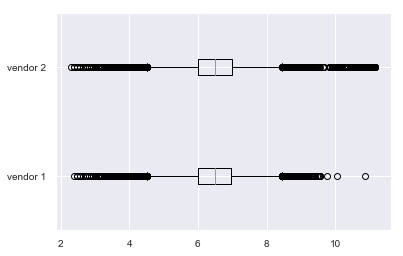

In [79]:
vendor_1 = dataset5['time'][dataset5['vendor'] == 1]
vendor_2 = dataset5['time'][dataset5['vendor'] == 2]
fig_10, ax_10 = plt.subplots()
ax_10.boxplot([np.log(vendor_1), np.log(vendor_2)], labels=['vendor 1', 'vendor 2'], vert=False)
fig_10.set_size_inches([6, 4])
#ax_10.scatter(vendor_2.unique(), vendor_2.value_counts())
plt.show()

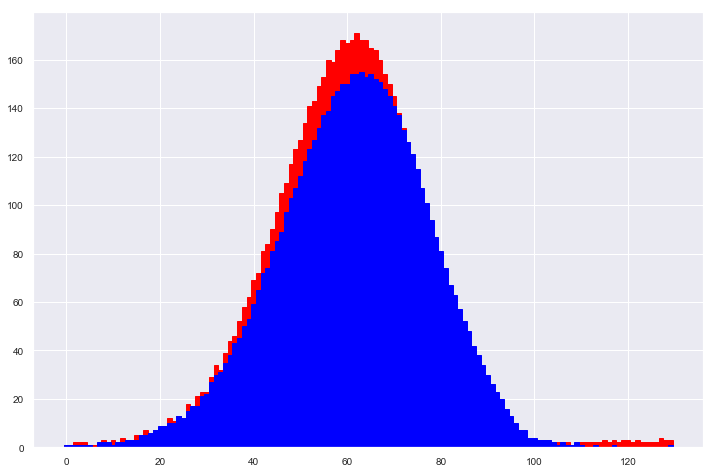

v1 median: 664.0
v2 median: 668.0
v1 mean: 838.0
v2 mean: 854.0
v1 std: 655.0
v2 std: 884.0


In [80]:
bins = 130
hist_1 = np.histogram(np.log(vendor_1), bins=bins)
hist_2 = np.histogram(np.log(vendor_2), bins=bins)
counts_1 = hist_1[0]
counts_2 = hist_2[0]
counts_1 = np.round(np.power(counts_1, 1/2))
counts_2 = np.round(np.power(counts_2, 1/2))
fig_20, ax_20 = plt.subplots()
ax_20.bar(np.arange(len(counts_2)), counts_2, width=1, color='red', edgecolor='red')
ax_20.bar(np.arange(len(counts_1)), counts_1, width=1, color='blue', edgecolor='blue')
fig_20.set_size_inches([12, 8])
plt.show()
print('v1 median:',vendor_1.median())
print('v2 median:' ,vendor_2.median())
print('v1 mean:',np.round(vendor_1.mean()))
print('v2 mean:',np.round(vendor_2.mean()))
print('v1 std:',np.round(vendor_1.std()))
print('v2 std:',np.round(vendor_2.std()))

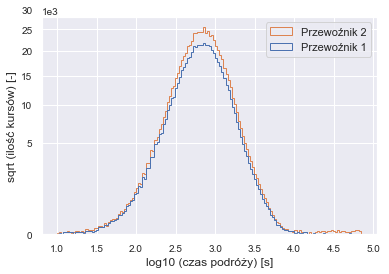

In [81]:
fig, ax = plt.subplots()
ax.hist([np.log10(vendor_1), np.log10(vendor_2)], bins=150, histtype='step', label=['Przewoźnik 1', 'Przewoźnik 2'])
#ax.hist(np.log10(vendor_2), bins=150, edgecolor='blue', color='blue')
ax.set_yscale('squareroot')
ax.ticklabel_format(axis='y', style='sci', scilimits=(3, 3))
ax.set_ylabel('sqrt (ilość kursów) [-]')
ax.set_xlabel('log10 (czas podróży) [s]')
fig.set_size_inches([6, 4])
ax.legend()
fig.savefig('time_dist_vendors.png', dpi=300, bbox_inches='tight')
plt.show()

#### flag a czas podróży

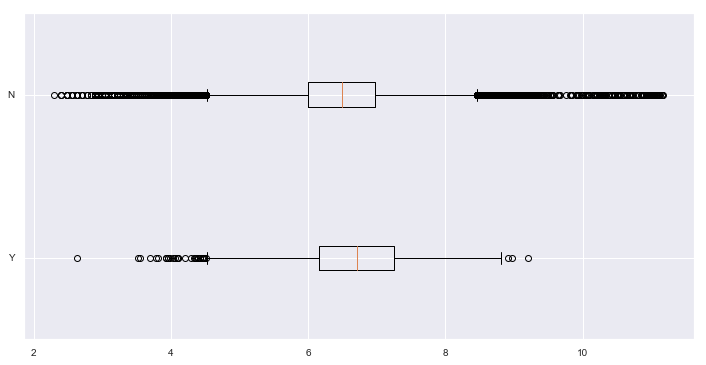

In [82]:
flag_Y = dataset5['time'][dataset5['flag'] == 'Y']
flag_N = dataset5['time'][dataset5['flag'] == 'N']
fig_11, ax_11 = plt.subplots()
ax_11.boxplot([np.log(flag_Y), np.log(flag_N)], labels=['Y', 'N'],  vert=False)
fig_11.set_size_inches([12, 6])
#ax_11.scatter(flag_2.unique(), flag_2.value_counts())
plt.show()

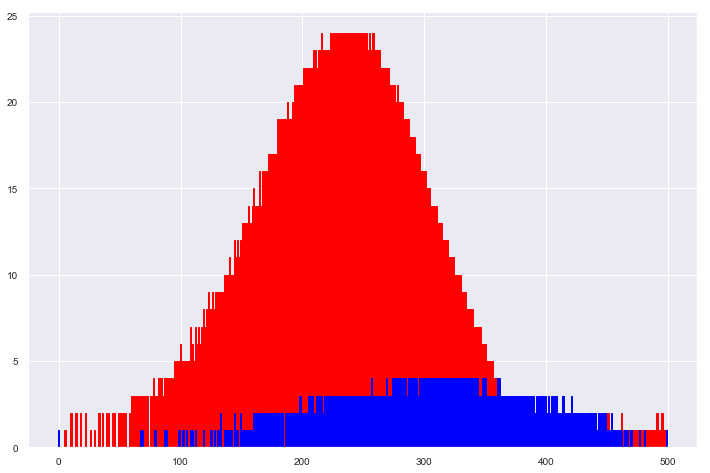

(16871, 24)

In [83]:
bins = 500
hist_1 = np.histogram(np.log(flag_Y), bins=bins)
hist_2 = np.histogram(np.log(flag_N), bins=bins)
counts_1 = hist_1[0]
counts_2 = hist_2[0]
counts_1 = np.round(np.power(counts_1, 1/3))
counts_2 = np.round(np.power(counts_2, 1/3))
fig_20, ax_20 = plt.subplots()
ax_20.bar(np.arange(len(counts_2)), counts_2, width=1, color='red', edgecolor='red')
ax_20.bar(np.arange(len(counts_1)), counts_1, width=1, color='blue', edgecolor='blue')
fig_20.set_size_inches([12, 8])
plt.show()
short.shape

#### dzień tygodnia, a czas podróży

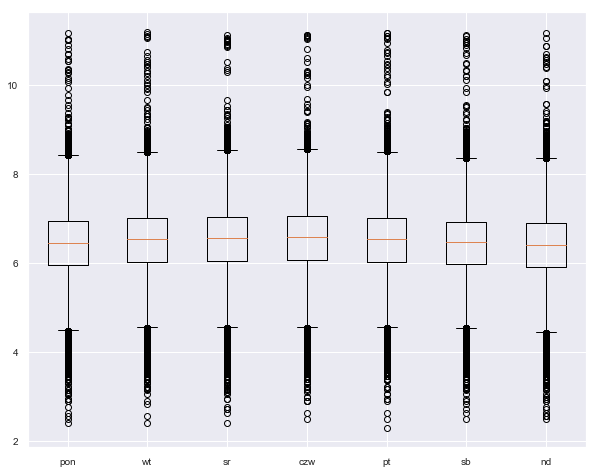

In [84]:
pon = np.log(dataset5['time'][dataset5['pick_weekday'] == 0])
wt = np.log(dataset5['time'][dataset5['pick_weekday'] == 1])
sr = np.log(dataset5['time'][dataset5['pick_weekday'] == 2])
czw = np.log(dataset5['time'][dataset5['pick_weekday'] == 3])
pt = np.log(dataset5['time'][dataset5['pick_weekday'] == 4])
sb = np.log(dataset5['time'][dataset5['pick_weekday'] == 5])
nd = np.log(dataset5['time'][dataset5['pick_weekday'] == 6])
fig_12, ax_12 = plt.subplots()
ax_12.boxplot([pon, wt, sr, czw, pt, sb, nd], labels=['pon', 'wt', 'sr', 'czw', 'pt', 'sb', 'nd'], vert=True)
fig_12.set_size_inches([10, 8])
#ax_11.scatter(pick_weekday_2.unique(), pick_weekday_2.value_counts())
plt.show()

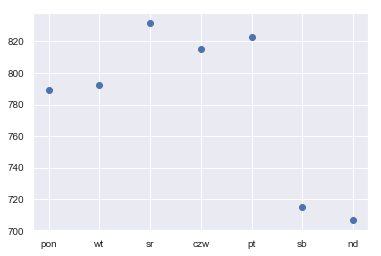

In [85]:
pon_std = dataset5['time'][dataset5['pick_weekday'] == 0].std()
wt_std = dataset5['time'][dataset5['pick_weekday'] == 1].std()
sr_std = dataset5['time'][dataset5['pick_weekday'] == 2].std()
czw_std = dataset5['time'][dataset5['pick_weekday'] == 3].std()
pt_std = dataset5['time'][dataset5['pick_weekday'] == 4].std()
sb_std = dataset5['time'][dataset5['pick_weekday'] == 5].std()
nd_std = dataset5['time'][dataset5['pick_weekday'] == 6].std()
weekday_std = [pon_std, wt_std, sr_std, czw_std, pt_std, sb_std, nd_std]
fig_12, ax_12 = plt.subplots()
ax_12.scatter(['pon', 'wt', 'sr', 'czw', 'pt', 'sb', 'nd'], weekday_std)
fig_12.set_size_inches([6, 4])
#ax_11.scatter(pick_weekday_2.unique(), pick_weekday_2.value_counts())
plt.show()

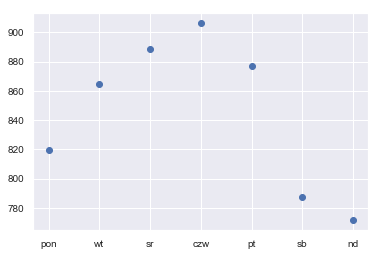

In [86]:
pon_mean = dataset5['time'][dataset5['pick_weekday'] == 0].mean()
wt_mean = dataset5['time'][dataset5['pick_weekday'] == 1].mean()
sr_mean = dataset5['time'][dataset5['pick_weekday'] == 2].mean()
czw_mean = dataset5['time'][dataset5['pick_weekday'] == 3].mean()
pt_mean = dataset5['time'][dataset5['pick_weekday'] == 4].mean()
sb_mean = dataset5['time'][dataset5['pick_weekday'] == 5].mean()
nd_mean = dataset5['time'][dataset5['pick_weekday'] == 6].mean()
weekday_mean = [pon_mean, wt_mean, sr_mean, czw_mean, pt_mean, sb_mean, nd_mean]
fig_12, ax_12 = plt.subplots()
ax_12.scatter(['pon', 'wt', 'sr', 'czw', 'pt', 'sb', 'nd'], weekday_mean)
fig_12.set_size_inches([6, 4])
#ax_11.scatter(pick_weekday_2.unique(), pick_weekday_2.value_counts())
plt.show()

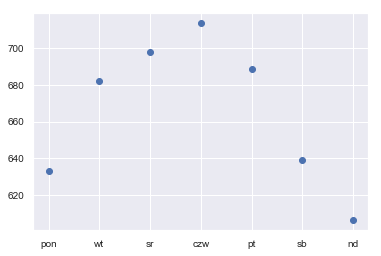

In [87]:
pon_median = dataset5['time'][dataset5['pick_weekday'] == 0].median()
wt_median = dataset5['time'][dataset5['pick_weekday'] == 1].median()
sr_median = dataset5['time'][dataset5['pick_weekday'] == 2].median()
czw_median = dataset5['time'][dataset5['pick_weekday'] == 3].median()
pt_median = dataset5['time'][dataset5['pick_weekday'] == 4].median()
sb_median = dataset5['time'][dataset5['pick_weekday'] == 5].median()
nd_median = dataset5['time'][dataset5['pick_weekday'] == 6].median()
weekday_median = [pon_median, wt_median, sr_median, czw_median, pt_median, sb_median, nd_median]
fig_12, ax_12 = plt.subplots()
ax_12.scatter(['pon', 'wt', 'sr', 'czw', 'pt', 'sb', 'nd'], weekday_median)
fig_12.set_size_inches([6, 4])
#ax_11.scatter(pick_weekday_2.unique(), pick_weekday_2.value_counts())
plt.show()

In [88]:
dni = ['', 'pon', 'wt', 'sr', 'czw', 'pt', 'sb', 'nd']
mediany = ['Mediana', pon_median, wt_median, sr_median, czw_median, pt_median, sb_median, nd_median]

In [89]:
srednie = ['Średnia', pon_mean, wt_mean, sr_mean, czw_mean, pt_mean, sb_mean, nd_mean]

In [90]:
odchylenia = ['Odchylenie STD', pon_std, wt_std, sr_std, czw_std, pt_std, sb_std, nd_std]

In [91]:
pd.DataFrame([mediany, srednie, odchylenia], columns=dni).set_index('').round(2)

,pon,wt,sr,czw,pt,sb,nd
,,,,,,,
Mediana,633.00,682.00,698.00,714.00,689.00,639.00,606.00
Średnia,819.52,864.58,888.62,906.62,876.72,787.30,771.33
Odchylenie STD,789.27,792.22,831.85,815.54,822.81,715.09,706.57


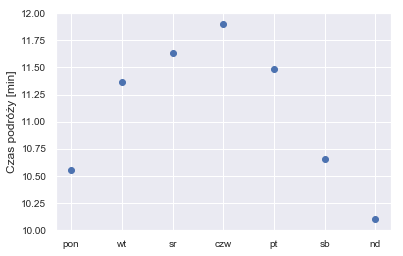

In [92]:
fig, ax = plt.subplots()
ax.scatter(dni[1:], np.array(weekday_median) / 60, label='Mediana')
#ax.scatter(dni, weekday_mean, label='Średnia')
#ax.scatter(dni, weekday_std)
#ax.legend()
ax.set_ylabel('Czas podróży [min]')
fig.set_size_inches([6, 4])
fig.savefig('time_weekdays_median.png', dpi=300, bbox_inches='tight')
plt.show()

#### liczba pasażerów, a czas podróży

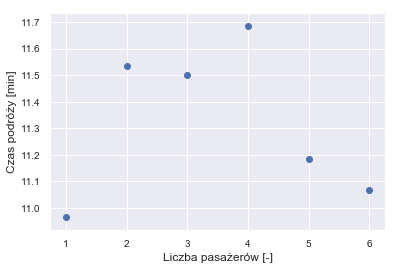

In [93]:
zero = dataset4['time'][dataset4['passengers'] == 0].median()
one = dataset5['time'][dataset5['passengers'] == 1].median()
two = dataset5['time'][dataset5['passengers'] == 2].median()
three = dataset5['time'][dataset5['passengers'] == 3].median()
four = dataset5['time'][dataset5['passengers'] == 4].median()
five = dataset5['time'][dataset5['passengers'] == 5].median()
six = dataset5['time'][dataset5['passengers'] == 6].median()
seven = dataset5['time'][dataset5['passengers'] == 7].median()
eight = dataset5['time'][dataset5['passengers'] == 8].median()
nine = dataset5['time'][dataset5['passengers'] == 9].median()
fig_13, ax_13 = plt.subplots()
ax_13.scatter(np.arange(1,7), np.array([one, two, three, four, five, six]) / 60)
ax_13.set_ylabel('Czas podróży [min]')
ax_13.set_xlabel('Liczba pasażerów [-]')
fig_13.set_size_inches([6, 4])
fig_13.savefig('time_passengers_median.png', dpi=300, bbox_inches='tight')
#ax_11.scatter(passengers_2.unique(), passengers_2.value_counts())
plt.show()

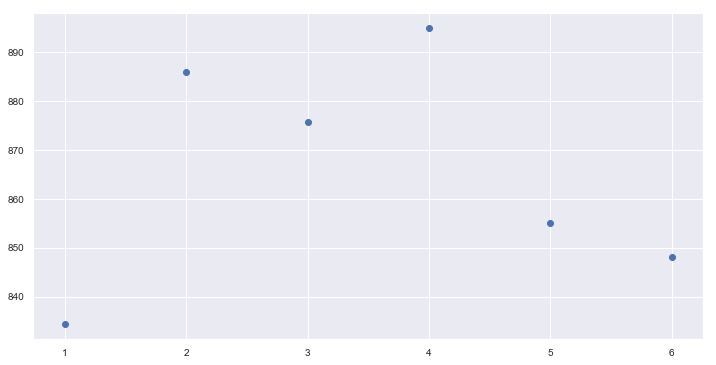

In [94]:
zero = dataset4['time'][dataset4['passengers'] == 0].mean()
one = dataset5['time'][dataset5['passengers'] == 1].mean()
two = dataset5['time'][dataset5['passengers'] == 2].mean()
three = dataset5['time'][dataset5['passengers'] == 3].mean()
four = dataset5['time'][dataset5['passengers'] == 4].mean()
five = dataset5['time'][dataset5['passengers'] == 5].mean()
six = dataset5['time'][dataset5['passengers'] == 6].mean()
seven = dataset5['time'][dataset5['passengers'] == 7].mean()
eight = dataset5['time'][dataset5['passengers'] == 8].mean()
nine = dataset5['time'][dataset5['passengers'] == 9].mean()
fig_13, ax_13 = plt.subplots()
ax_13.scatter(np.arange(1,7), [one, two, three, four, five, six])
fig_13.set_size_inches([12, 6])
#ax_11.scatter(passengers_2.unique(), passengers_2.value_counts())
plt.show()

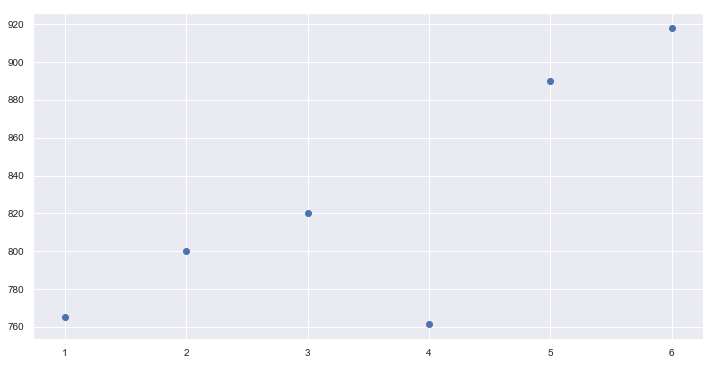

In [95]:
zero = dataset4['time'][dataset4['passengers'] == 0].std()
one = dataset5['time'][dataset5['passengers'] == 1].std()
two = dataset5['time'][dataset5['passengers'] == 2].std()
three = dataset5['time'][dataset5['passengers'] == 3].std()
four = dataset5['time'][dataset5['passengers'] == 4].std()
five = dataset5['time'][dataset5['passengers'] == 5].std()
six = dataset5['time'][dataset5['passengers'] == 6].std()
seven = dataset5['time'][dataset5['passengers'] == 7].std()
eight = dataset5['time'][dataset5['passengers'] == 8].std()
nine = dataset5['time'][dataset5['passengers'] == 9].std()
fig_13, ax_13 = plt.subplots()
ax_13.scatter(np.arange(1,7), [one, two, three, four, five, six])
fig_13.set_size_inches([12, 6])
#ax_11.scatter(passengers_2.unique(), passengers_2.value_counts())
plt.show()

In [96]:
zero = dataset4['time'][dataset4['passengers'] == 0]
one = dataset5['time'][dataset5['passengers'] == 1]
two = dataset5['time'][dataset5['passengers'] == 2]
three = dataset5['time'][dataset5['passengers'] == 3]
four = dataset5['time'][dataset5['passengers'] == 4]
five = dataset5['time'][dataset5['passengers'] == 5]
six = dataset5['time'][dataset5['passengers'] == 6]
seven = dataset5['time'][dataset5['passengers'] == 7]
eight = dataset5['time'][dataset5['passengers'] == 8]
nine = dataset5['time'][dataset5['passengers'] == 9]
for count in [one, two, three, four, five, six]: print(count.size)


1019759
207862
59231
28039
77136
47649


#### miesiąc, a czas podróży

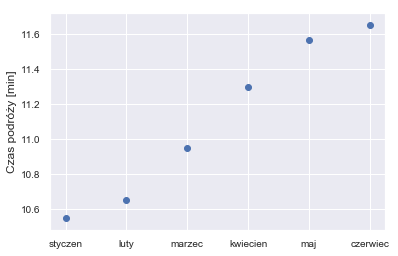

In [97]:
styczen = dataset5['time'][dataset5['pick_month'] == 1].median()
luty = dataset5['time'][dataset5['pick_month'] == 2].median()
marzec = dataset5['time'][dataset5['pick_month'] == 3].median()
kwiecien = dataset5['time'][dataset5['pick_month'] == 4].median()
maj = dataset5['time'][dataset5['pick_month'] == 5].median()
czerwiec = dataset5['time'][dataset5['pick_month'] == 6].median()

month_medians = ['Mediana', styczen, luty, marzec, kwiecien, maj, czerwiec]

fig_14, ax_14 = plt.subplots()
ax_14.scatter(['styczen', 'luty', 'marzec', 'kwiecien', 'maj', 'czerwiec'],
              np.array([styczen, luty, marzec, kwiecien, maj, czerwiec]) / 60)
ax_14.set_ylabel('Czas podróży [min]')
fig_14.set_size_inches([6, 4])
fig_14.savefig('time_months_median.png', dpi=300, bbox_inches='tight')
#ax_14.scatter(pick_month_2.unique(), pick_month_2.value_counts())
plt.show()

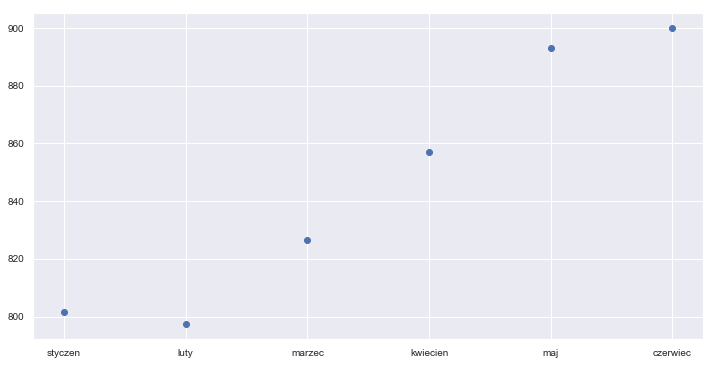

In [98]:
styczen = dataset5['time'][dataset5['pick_month'] == 1].mean()
luty = dataset5['time'][dataset5['pick_month'] == 2].mean()
marzec = dataset5['time'][dataset5['pick_month'] == 3].mean()
kwiecien = dataset5['time'][dataset5['pick_month'] == 4].mean()
maj = dataset5['time'][dataset5['pick_month'] == 5].mean()
czerwiec = dataset5['time'][dataset5['pick_month'] == 6].mean()

month_means = ['Średnia', styczen, luty, marzec, kwiecien, maj, czerwiec]

fig_14, ax_14 = plt.subplots()
ax_14.scatter(['styczen', 'luty', 'marzec', 'kwiecien', 'maj', 'czerwiec'],
              [styczen, luty, marzec, kwiecien, maj, czerwiec])
fig_14.set_size_inches([12, 6])
#ax_14.scatter(pick_month_2.unique(), pick_month_2.value_counts())
plt.show()

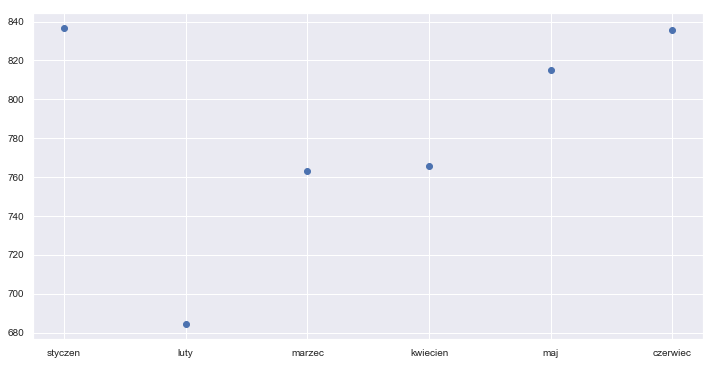

In [99]:
styczen = dataset5['time'][dataset5['pick_month'] == 1].std()
luty = dataset5['time'][dataset5['pick_month'] == 2].std()
marzec = dataset5['time'][dataset5['pick_month'] == 3].std()
kwiecien = dataset5['time'][dataset5['pick_month'] == 4].std()
maj = dataset5['time'][dataset5['pick_month'] == 5].std()
czerwiec = dataset5['time'][dataset5['pick_month'] == 6].std()

month_stds = ['Odchylenie STD', styczen, luty, marzec, kwiecien, maj, czerwiec]

fig_14, ax_14 = plt.subplots()
ax_14.scatter(['styczen', 'luty', 'marzec', 'kwiecien', 'maj', 'czerwiec'],
              [styczen, luty, marzec, kwiecien, maj, czerwiec])
fig_14.set_size_inches([12, 6])
#ax_14.scatter(pick_month_2.unique(), pick_month_2.value_counts())
plt.show()

In [100]:
miesiace = ['', 'styczen', 'luty', 'marzec', 'kwiecien', 'maj', 'czerwiec']
pd.DataFrame([month_medians, month_means, month_stds], columns=miesiace).set_index('').round(2)

,styczen,luty,marzec,kwiecien,maj,czerwiec
,,,,,,
Mediana,633.00,639.00,657.00,678.00,694.00,699.00
Średnia,801.71,797.26,826.67,857.00,892.98,900.02
Odchylenie STD,836.67,684.22,763.17,765.65,814.91,835.64


#### godzina, a czas podróży

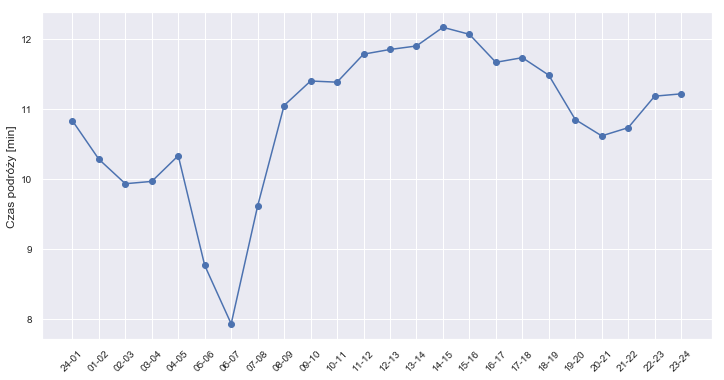

In [101]:
hours_median = []
hours_mean = []
hours_std = []

for hour in range(0, 24):
    time_in_hour = dataset5[dataset5['pick_hour'] == hour]['time']
    hours_median.append(time_in_hour.median())
    hours_mean.append(time_in_hour.mean())
    hours_std.append(time_in_hour.std())
    
fig_15, ax_15 = plt.subplots()
ax_15.plot(godziny, np.array(hours_median) / 60, marker='o')
ax_15.set_xticklabels(godziny, rotation=45)
ax_15.set_ylabel('Czas podróży [min]')
#ax_15.set_title('std')
fig_15.set_size_inches([12, 6])
fig_15.savefig('time_hours_median.png', dpi=300, bbox_inches='tight')
plt.show()

In [102]:
medians = ['Mediana'] + hours_median
means = ['Średnia'] + hours_mean
stds =['Odchylenie STD'] + hours_std
godz = [''] + godziny

In [103]:
display(pd.DataFrame([medians[0:12], means[0:12], stds[0:12]], columns=godz[0:12]).set_index('').round(2))
display(pd.DataFrame([hours_median[12:], hours_mean[12:], hours_std[12:]], columns=godziny[12:]).round(2))

,24-01,01-02,02-03,03-04,04-05,05-06,06-07,07-08,08-09,09-10,10-11
,,,,,,,,,,,
Mediana,650.00,617.00,596.00,598.00,620.00,526.00,476.00,577.00,663.00,684.00,683.00
Średnia,787.26,745.69,708.09,710.44,763.14,770.67,695.49,773.01,842.99,852.84,855.48
Odchylenie STD,574.28,529.73,473.78,480.31,1235.67,1898.38,1257.88,1053.05,819.44,804.59,740.80


,12-13,13-14,14-15,15-16,16-17,17-18,18-19,19-20,20-21,21-22,22-23,23-24
0,711.00,714.00,730.00,724.00,700.00,704.00,689.00,651.00,637.00,644.00,671.00,673.00
1,887.19,908.46,958.44,979.93,977.63,940.74,867.34,794.10,774.38,781.91,809.03,817.36
2,757.83,820.97,859.98,951.25,947.98,838.13,690.95,567.34,561.37,569.87,557.59,562.92


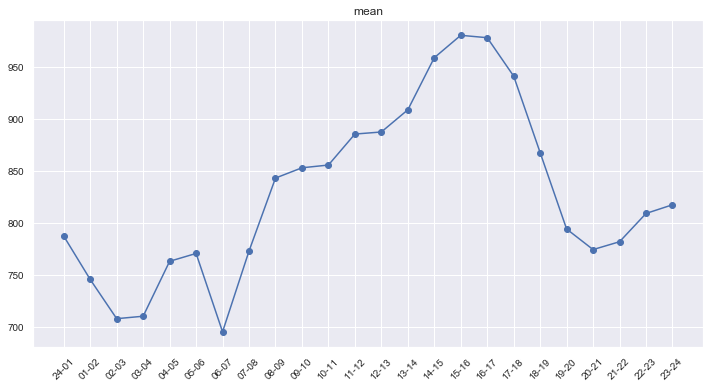

In [104]:
hours_mean = []
for hour in range(0, 24):
    time_in_hour = dataset5[dataset5['pick_hour'] == hour]['time']
    hours_mean.append(time_in_hour.mean())

fig_15, ax_15 = plt.subplots()
ax_15.plot(godziny, hours_mean, marker='o')
ax_15.set_xticklabels(godziny, rotation=45)
ax_15.set_title('mean')
fig_15.set_size_inches([12, 6])
plt.show()

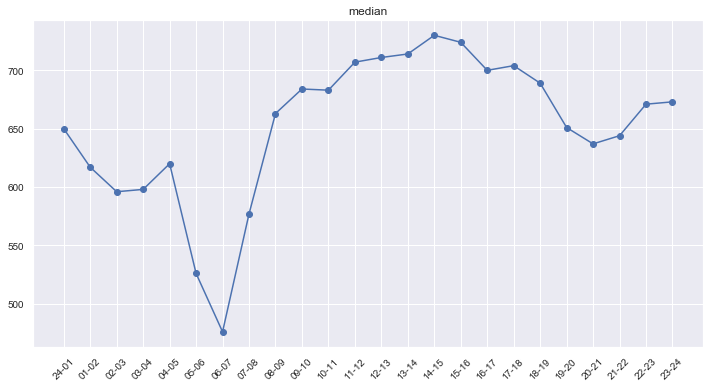

In [105]:
hours_median = []
for hour in range(0, 24):
    time_in_hour = dataset5[dataset5['pick_hour'] == hour]['time']
    hours_median.append(time_in_hour.median())

fig_15, ax_15 = plt.subplots()
ax_15.plot(godziny, hours_median, marker='o')
ax_15.set_xticklabels(godziny, rotation=45)
ax_15.set_title('median')
fig_15.set_size_inches([12, 6])
plt.show()

#### Pick long, lat a czas podróży

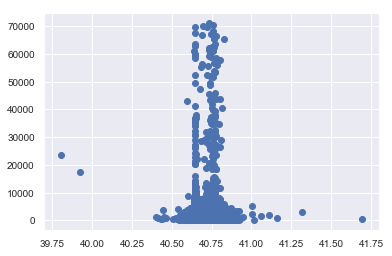

In [106]:
lats = dataset5['pick_lat']
fig, ax = plt.subplots()
ax.scatter(lats, dataset5['time'])

In [107]:
#lats = dataset5['pick_lat']
#longs = dataset5['pick_long']
lats = np.round(dataset5['pick_lat'], 5)
longs = np.round(dataset5['pick_long'], 5)
print(lats[0], longs[0])
print(lats.unique().size)

40.76794 -73.98215
19913


In [108]:
means, medians, stds = [], [], []
for lat in lats.unique():
    
    times_for_lat = dataset5[lats == lat]['time']
    mean_for_lat = times_for_lat.mean()
    median_for_lat = times_for_lat.median()
    std_for_lat = times_for_lat.std()
    
    means.append(mean_for_lat)
    medians.append(median_for_lat)
    stds.append(std_for_lat)

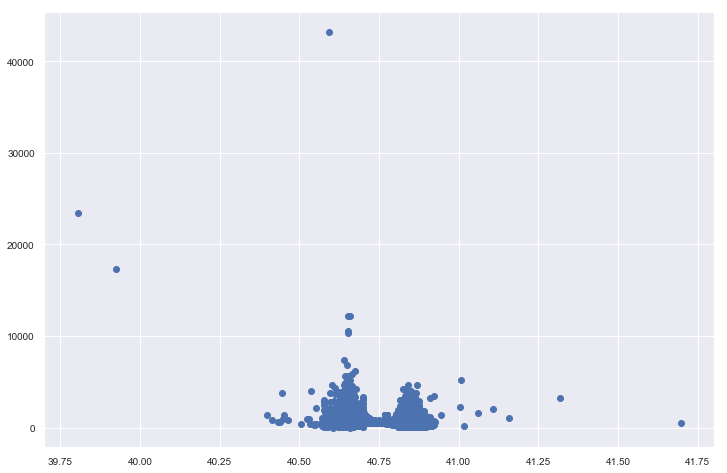

In [109]:
fig, ax = plt.subplots()
ax.scatter(lats.unique(), medians)
fig.set_size_inches([12, 8])

#### dzień tygodnia x godzina x mediana 

In [110]:
dataset5.head(n=1)

,vendor,pick_date,drop_date,pick_weekday,pick_day,pick_month,pick_hour,pick_minute,pick_second,drop_weekday,...,drop_second,passengers,pick_lat,pick_long,drop_lat,drop_long,flag,time,distance,speed
0,2,2016-03-14 17:24:55,2016-03-14 17:32:30,0,14,3,17,24,55,0,...,30,1,40.767937,-73.982155,40.765602,-73.96463,N,455,1499.0,11.86022


In [111]:
hours = dataset5['pick_hour'].unique()
hours = np.sort(hours)
weekdays = dataset5['pick_weekday'].unique()
weekdays = np.sort(weekdays)
months = dataset5['pick_month'].unique()
months = np.sort(months)
print(weekdays)
print(hours)
print(months)

[0 1 2 3 4 5 6]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
[1 2 3 4 5 6]


In [112]:
month_means = np.zeros([6, 7, 24])
month_medians = np.zeros([6, 7, 24])
month_stds = np.zeros([6, 7, 24])
for month in months:
    for weekday in weekdays:
        for hour in hours:
            times = dataset5[(dataset5['pick_month'] == month) &
                             (dataset5['pick_weekday'] == weekday) &
                             (dataset5['pick_hour'] == hour)]['time']

            month_means[month-1, weekday, hour] = times.mean()
            month_medians[month-1, weekday, hour] = times.median()
            month_stds[month-1, weekday, hour] = times.std()

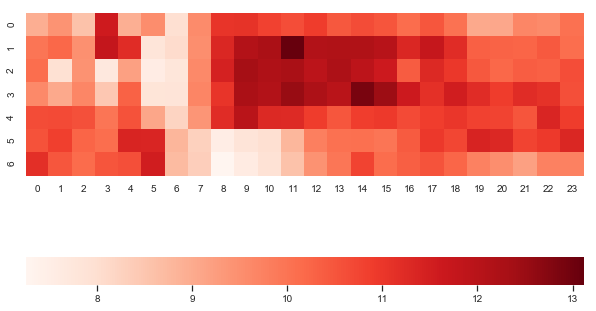

In [113]:
fig, ax = plt.subplots()
ax = sns.heatmap(month_medians[0, :, :] / 60, cmap='Reds', square=True, cbar_kws={"orientation": "horizontal"})
fig.savefig('heat_map.png', dpi=300, bbox_inches='tight')
fig.set_size_inches([10, 10])

In [114]:
means = np.zeros([7, 24])
medians = np.zeros([7, 24])
stds = np.zeros([7, 24])
for weekday in weekdays:
    for hour in hours:
        times = dataset5[(dataset5['pick_weekday'] == weekday) &
                         (dataset5['pick_hour'] == hour)]['time']

        means[weekday, hour] = times.mean()
        medians[weekday, hour] = times.median()
        stds[weekday, hour] = times.std()

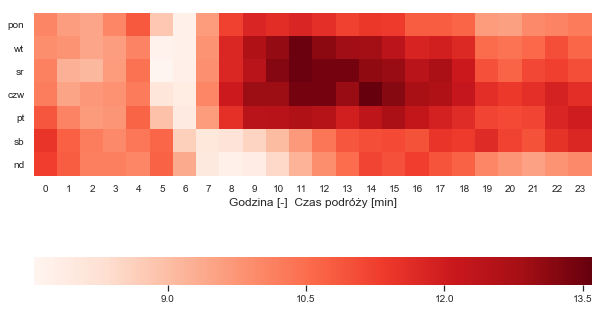

In [115]:
fig, ax = plt.subplots()
ax = sns.heatmap(medians / 60, cmap='Reds', square=True, cbar_kws={"orientation": "horizontal"})
ax.set_xlabel('Godzina [-]  Czas podróży [min]')
ax.set_yticklabels(dni[1:], rotation=0) 
fig.savefig('heat_map_med.png', dpi=300, bbox_inches='tight')
fig.set_size_inches([10, 10])

In [116]:
## wtorek to piatek and 8 do 18
heat_days = (dataset5['pick_weekday'] >= 1) & (dataset5['pick_weekday'] <= 4)
heat_hours = (dataset5['pick_hour'] >= 8) & (dataset5['pick_hour'] <= 18)
#print(dataset5[heat_days]['pick_weekday'].unique())
#print(np.sort(dataset5[heat_hours]['pick_hour'].unique()))
#dataset5[(heat_days) & (heat_hours)]
long_trip = (heat_days & heat_hours).astype(int)

In [117]:
#dataset5.insert(loc=24, column='long_trip', value=long_trip)

In [118]:
#dataset5.head(n=2)

#### mediana srednia std czasu dla dzien x godzina 

In [119]:
dataset5.insert(loc=24, column='week_h_median', value=np.zeros(dataset5.shape[0]))
dataset5.insert(loc=25, column='week_h_mean', value=np.zeros(dataset5.shape[0]))
dataset5.insert(loc=26, column='week_h_std', value=np.zeros(dataset5.shape[0]))

In [120]:
for weekday in weekdays:
    for hour in hours:
        indexes = dataset5[(dataset5['pick_weekday']==weekday) & (dataset5['pick_hour']==hour)].index
        dataset5.at[indexes, 'week_h_median'] = medians[weekday, hour]
        dataset5.at[indexes, 'week_h_mean'] = means[weekday, hour]
        dataset5.at[indexes, 'week_h_std'] = stds[weekday, hour]

In [121]:
dataset5[(dataset5['pick_weekday']==1) & (dataset5['pick_hour']==5)]

,vendor,pick_date,drop_date,pick_weekday,pick_day,pick_month,pick_hour,pick_minute,pick_second,drop_weekday,...,pick_long,drop_lat,drop_long,flag,time,distance,speed,week_h_median,week_h_mean,week_h_std
1147,1,2016-01-19 05:56:10,2016-01-19 06:04:57,1,19,1,5,56,10,1,...,-73.994324,40.760590,-73.977303,N,527,1788.0,12.214042,459.5,730.847368,2131.70029
1428,1,2016-04-05 05:06:38,2016-04-05 05:19:20,1,5,4,5,6,38,1,...,-73.977554,40.805019,-73.941208,N,762,7219.0,34.105512,459.5,730.847368,2131.70029
1623,1,2016-04-26 05:24:55,2016-04-26 05:29:45,1,26,4,5,24,55,1,...,-73.965706,40.763897,-73.954140,N,290,986.0,12.240000,459.5,730.847368,2131.70029
3220,1,2016-06-28 05:11:39,2016-06-28 05:40:41,1,28,6,5,11,39,1,...,-73.780495,40.772160,-73.979057,N,1742,21828.0,45.109529,459.5,730.847368,2131.70029
3312,1,2016-02-16 05:24:44,2016-02-16 05:28:22,1,16,2,5,24,44,1,...,-73.985847,40.688610,-73.991112,N,218,599.0,9.891743,459.5,730.847368,2131.70029
3511,2,2016-05-31 05:24:08,2016-05-31 05:32:03,1,31,5,5,24,8,1,...,-73.943657,40.764118,-73.966820,N,475,3381.0,25.624421,459.5,730.847368,2131.70029
4541,2,2016-05-24 05:04:15,2016-05-24 05:07:02,1,24,5,5,4,15,1,...,-73.950500,40.775440,-73.958267,N,167,1129.0,24.337725,459.5,730.847368,2131.70029
6296,1,2016-02-09 05:35:35,2016-02-09 05:53:35,1,9,2,5,35,35,1,...,-73.955070,40.715534,-74.013306,N,1080,5955.0,19.850000,459.5,730.847368,2131.70029
6528,2,2016-06-07 05:31:34,2016-06-07 05:36:57,1,7,6,5,31,34,1,...,-73.989357,40.750011,-73.994972,N,323,2070.0,23.071207,459.5,730.847368,2131.70029
6551,1,2016-01-05 05:25:27,2016-01-05 05:49:58,1,5,1,5,25,27,1,...,-73.978951,40.694080,-74.176857,N,1471,17746.0,43.430048,459.5,730.847368,2131.70029


#### mediana srednia std predkosci dla dzien x godzina 

In [122]:
means_v = np.zeros([7, 24])
medians_v = np.zeros([7, 24])
stds_v = np.zeros([7, 24])
for weekday in weekdays:
    for hour in hours:
        speeds = dataset5[(dataset5['pick_weekday'] == weekday) &
                         (dataset5['pick_hour'] == hour)]['speed']

        means_v[weekday, hour] = speeds.mean()
        medians_v[weekday, hour] = speeds.median()
        stds_v[weekday, hour] = speeds.std()

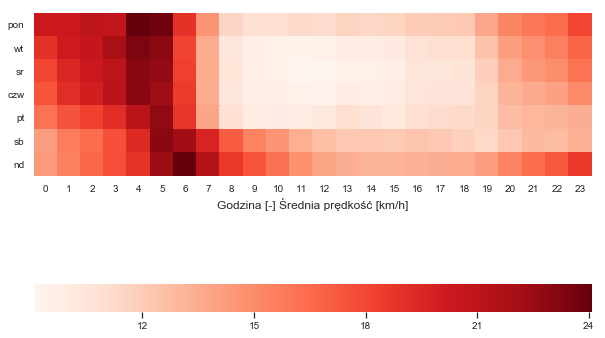

In [123]:
fig, ax = plt.subplots()
ax = sns.heatmap(medians_v, cmap='Reds', square=True, cbar_kws={"orientation": "horizontal", 'pad': 0.2})
ax.set_xlabel('Godzina [-] Średnia prędkość [km/h]')
ax.set_yticklabels(dni[1:], rotation=0) 
fig.savefig('heat_map_v.png', dpi=300)
fig.set_size_inches([10, 10])

In [124]:
dataset5.insert(loc=27, column='week_h_median_v', value=np.zeros(dataset5.shape[0]))
dataset5.insert(loc=28, column='week_h_mean_v', value=np.zeros(dataset5.shape[0]))
dataset5.insert(loc=29, column='week_h_std_v', value=np.zeros(dataset5.shape[0]))

In [125]:
for weekday in weekdays:
    for hour in hours:
        indexes = dataset5[(dataset5['pick_weekday']==weekday) & (dataset5['pick_hour']==hour)].index
        dataset5.at[indexes, 'week_h_median_v'] = medians_v[weekday, hour]
        dataset5.at[indexes, 'week_h_mean_v'] = means_v[weekday, hour]
        dataset5.at[indexes, 'week_h_std_v'] = stds_v[weekday, hour]

#### Odległość w lini prostej a czas podróży

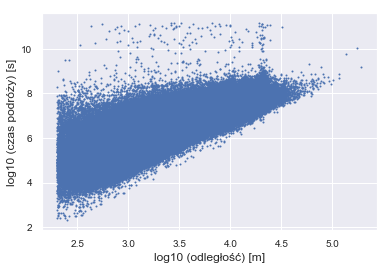

In [126]:
fig, ax = plt.subplots()
ax.scatter(np.log10(dataset5['distance']), np.log(dataset5['time']), s=1)
ax.set_ylabel('log10 (czas podróży) [s]')
ax.set_xlabel('log10 (odległość) [m]')
fig.savefig('distance_time.png', dpi=300, bbox_inches='tight')
fig.set_size_inches([6, 4])
plt.show()

#### podróże na lotniska

#### JFK

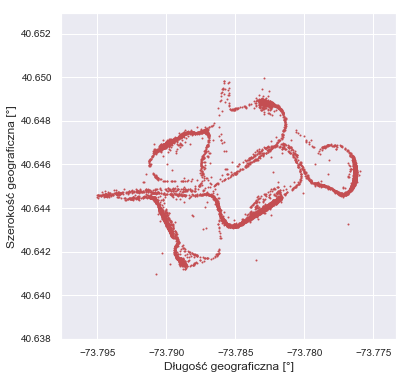

In [127]:
jfk_drop = (dataset5['drop_lat'] < 40.65) & (dataset5['drop_lat'] > 40.64) & (dataset5['drop_long'] < -73.77) & (dataset5['drop_long'] > -73.795)
jfk_pick = (dataset5['pick_lat'] < 40.65) & (dataset5['pick_lat'] > 40.64) & (dataset5['pick_long'] < -73.77) & (dataset5['pick_long'] > -73.795)
fig, ax = plt.subplots()
ax.scatter(np.round(dataset5[jfk_drop]['drop_long'], 6), np.round(dataset5['drop_lat'][jfk_drop], 6), s=1, c='r')
ax.set_xlabel('Długość geograficzna [°]')
ax.set_ylabel('Szerokość geograficzna [°]')
fig.set_size_inches([6, 6])
fig.savefig('jfk.png', dpi=300, bbox_inches='tight')
plt.show()

In [128]:
print(dataset5[jfk_drop]['time'].mean() / 60)
print(dataset5[jfk_drop]['time'].median() / 60)
print(dataset5[jfk_drop]['time'].std() / 60, '\n')

print(dataset5[jfk_pick]['time'].mean() / 60)
print(dataset5[jfk_pick]['time'].median() / 60)
print(dataset5[jfk_pick]['time'].std() / 60, '\n')

print(dataset5['time'].mean() / 60)
print(dataset5['time'].median() / 60)
print(dataset5['time'].std() / 60, '\n')

45.142452394157885
42.0
24.714887442925296 

42.26532123660365
39.233333333333334
28.557080574042413 

14.10397417731132
11.1
13.092237292521085 



In [129]:
jfk = jfk_pick | jfk_drop
jfk = jfk.astype(int)
dataset5.insert(loc=24, column='jfk', value=jfk)

In [130]:
dataset5['jfk'].value_counts()

0    1398915
1      40775
Name: jfk, dtype: int64

#### LaGuardia

In [131]:
left, right, up, down = -73.875, -73.86, 40.775, 40.766

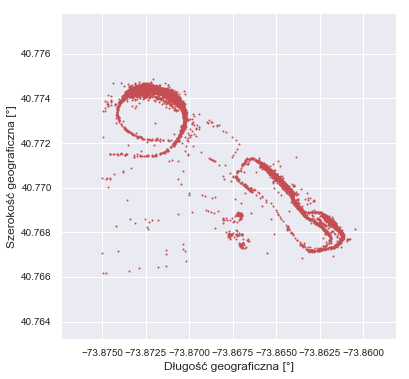

In [132]:
lagu_drop = (dataset5['drop_lat'] < up) & (dataset5['drop_lat'] > down) & (dataset5['drop_long'] < right) & (dataset5['drop_long'] > left)
lagu_pick = (dataset5['pick_lat'] < up) & (dataset5['pick_lat'] > down) & (dataset5['pick_long'] < right) & (dataset5['pick_long'] > left)
fig, ax = plt.subplots()
ax.scatter(np.round(dataset5[lagu_drop]['drop_long'], 6), np.round(dataset5['drop_lat'][lagu_drop], 6), s=1, c='r')
ax.set_xlabel('Długość geograficzna [°]')
ax.set_ylabel('Szerokość geograficzna [°]')
fig.set_size_inches([6, 6])
fig.savefig('lagu.png', dpi=300, bbox_inches='tight')
plt.show()

In [133]:
print(dataset5[lagu_drop]['time'].mean() / 60)
print(dataset5[lagu_drop]['time'].median() / 60)
print(dataset5[lagu_drop]['time'].std() / 60, '\n')

print(dataset5[lagu_pick]['time'].mean() / 60)
print(dataset5[lagu_pick]['time'].median() / 60)
print(dataset5[lagu_pick]['time'].std() / 60, '\n')

print(dataset5['time'].mean() / 60)
print(dataset5['time'].median() / 60)
print(dataset5['time'].std() / 60, '\n')

28.434976442174445
26.125
16.641400079613327 

30.769588414634146
28.183333333333334
17.081980401567105 

14.10397417731132
11.1
13.092237292521085 



In [134]:
lagu = lagu_pick | lagu_drop
lagu = lagu.astype(int)
dataset5.insert(loc=25, column='lagu', value=lagu)

In [135]:
dataset5['lagu'].value_counts()

0    1388287
1      51403
Name: lagu, dtype: int64

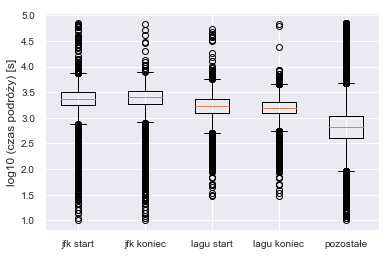

In [136]:
jfk_pick_t = np.log10(dataset5[jfk_pick]['time'])
jfk_drop_t = np.log10(dataset5[jfk_drop]['time'])
lagu_pick_t = np.log10(dataset5[lagu_pick]['time'])
lagu_drop_t = np.log10(dataset5[lagu_drop]['time'])
rest = np.log10(dataset5['time'])
fig, ax = plt.subplots()
ax.boxplot([jfk_pick_t, jfk_drop_t, lagu_pick_t, lagu_drop_t, rest])
ax.set_xticklabels(['jfk start', 'jfk koniec', 'lagu start', 'lagu koniec', 'pozostałe'])
ax.set_ylabel('log10 (czas podróży) [s]')
fig.savefig('box.png', dpi=300, bbox_inches='tight')
plt.show()

#### odległość taksówkowa

In [137]:
a_lat = dataset5.iloc[[1]]['pick_lat']
a_long = dataset5.iloc[[1]]['pick_long']
b_lat = dataset5.iloc[[1]]['drop_lat']
b_long = dataset5.iloc[[1]]['drop_long']
haversine_distance(a_lat, a_long, b_lat, b_long)

1    1806.0
dtype: float64

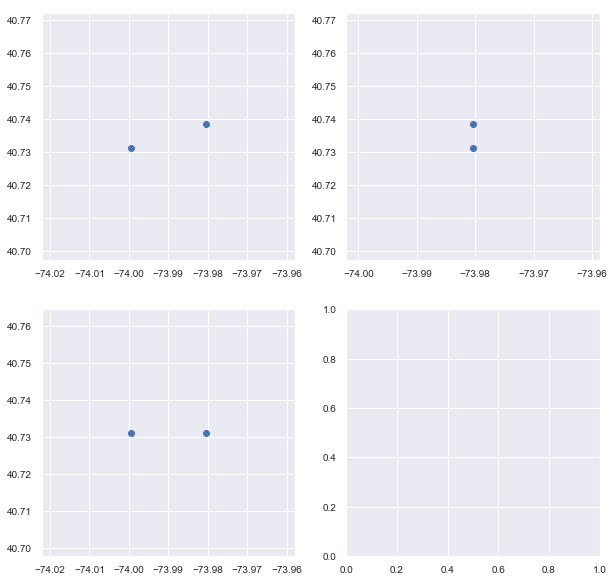

In [138]:
fig, ax = plt.subplots(2, 2)
ax[0, 0].scatter([a_long, b_long], [a_lat, b_lat])
ax[0, 1].scatter([a_long, a_long], [a_lat, b_lat])
ax[1, 0].scatter([a_long, b_long], [b_lat, b_lat])
fig.set_size_inches([10, 10])
plt.show()

In [139]:
c = haversine_distance(a_lat, a_long, b_lat, b_long)
a = haversine_distance(a_lat, a_long, b_lat, a_long)
b = haversine_distance(b_lat, a_long, b_lat, b_long)
print(c)
print(a)
print(b)

1    1806.0
dtype: float64
1    824.0
dtype: float64
1    1607.0
dtype: float64


In [140]:
a_lat = dataset5['pick_lat'].values
a_long = dataset5['pick_long'].values
# vert distances
bv_lat = dataset5['drop_lat'].values
bv_long = dataset5['pick_long'].values
# horiz distances
bh_lat = dataset5['pick_lat'].values
bh_long = dataset5['drop_long'].values

In [141]:
verts = haversine_distance(a_lat, a_long, bv_lat, bv_long)
horizs = haversine_distance(a_lat, a_long, bh_lat, bh_long)
taxi_distance = verts + horizs
diagonal = np.sqrt(np.power(verts, 2) + np.power(horizs, 2))
diagonal = np.round(diagonal)
diffs = diagonal - dataset5['distance'].values

In [142]:
dataset5.insert(loc=24, column='taxi_distance', value=taxi_distance)

#### odległość taxówkowa a czas podróży

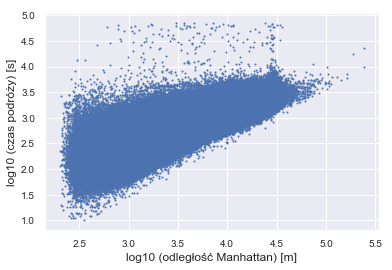

In [144]:
fig, ax = plt.subplots()
ax.scatter(np.log10(dataset5['taxi_distance']), np.log10(dataset5['time']), s=1)
ax.set_ylabel('log10 (czas podróży) [s]')
ax.set_xlabel('log10 (odległość Manhattan) [m]')
fig.set_size_inches([6, 4])
fig.savefig('taxi_distance_time.png', dpi=300, bbox_inches='tight')
plt.show()

In [141]:
difference = np.sqrt(np.power(dataset5['distance'] - dataset5['taxi_distance'] ,2))

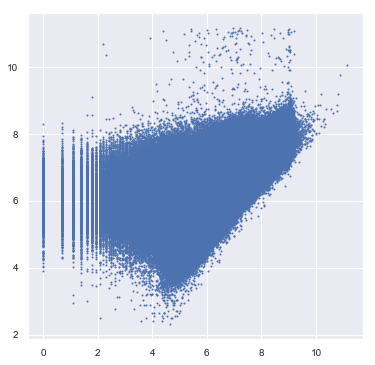

In [142]:
fig, ax = plt.subplots()
ax.scatter(np.log(difference), np.log(dataset5['time']), s=1)
fig.set_size_inches([6, 6])
plt.show()

## Modelowanie

In [3]:
from sklearn.model_selection import train_test_split
import sklearn.linear_model as lm
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
#from keras.layers import Dense, Activation, BatchNormalization
#from keras.models import Sequential
#from keras.optimizers import Adam
#from keras.metrics import mean_squared_error as mse
#from keras.metrics import mean_absolute_percentage_error as mape
#import keras
import xgboost as xgb
from sklearn.preprocessing import normalize
from sklearn.tree import DecisionTreeRegressor
import time
from sklearn.neighbors import KNeighborsRegressor

### przygotaowanie datasetu

In [6]:
dataset5.keys()

NameError: name 'dataset5' is not defined

In [7]:
model = dataset5.drop(columns=['pick_date', 'pick_minute', 'pick_second', 'drop_date', 'pick_day', 'drop_weekday', 'drop_day', 'drop_month',
                       'drop_hour', 'drop_minute', 'drop_second', 'flag', 'speed'])

model = model[['vendor', 'pick_weekday', 'pick_month', 'pick_hour', 'passengers',
               'jfk', 'lagu', 'pick_lat', 'pick_long', 'drop_lat', 'drop_long',
               'week_h_median', 'week_h_mean', 'week_h_std', 'week_h_median_v',
               'week_h_mean_v', 'week_h_std_v', 'taxi_distance', 'distance', 'time']]

model.head(n=2)

NameError: name 'dataset5' is not defined

In [166]:
model.to_csv('model.csv', index=False)

In [5]:
model = pd.read_csv('model.csv')

In [ ]:
# for neural network

model_val = model.values
means = model.values[:, 8:].mean(axis=0)
normalized = model.values[:, 8:] - means
model_val[:, 8:] = normalized

sigma_sq = (np.sum(np.power(model_val[:, 8:], 2), axis=0)) / (model_val[:, 8].shape[0] - 1)
sigma = np.sqrt(sigma_sq)
standarized = model_val[:, 8:] / sigma
model_val[:, 8:] = standarized

In [8]:
X = model.values[:, 0:-1]
y = model.values[:, -1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

In [9]:
model.head(n=1)

,vendor,pick_weekday,pick_month,pick_hour,passengers,jfk,lagu,pick_lat,pick_long,drop_lat,drop_long,week_h_median,week_h_mean,week_h_std,week_h_median_v,week_h_mean_v,week_h_std_v,taxi_distance,distance,time
0,2,0,3,17,1,0,0,40.767937,-73.982155,40.765602,-73.96463,647.0,874.836257,785.185526,12.117708,13.123123,5.91453,1736.0,1499.0,455


#### metryki

In [14]:
def mape(y_true, y_pred):
    errs = np.sqrt(np.power(((y_true - y_pred) / y_true), 2))
    mean = (np.sum(errs) / errs.shape[0]) * 100
    return mean

In [15]:
def rmsle(y_true, y_pred) : 
    assert len(y_true) == len(y_pred)
    return np.sqrt(np.mean((np.log(1+y_pred) - np.log(1+y_true))**2))

#### regressia liniowa

In [10]:
lin_reg = lm.LinearRegression(n_jobs=-1)

In [11]:
ling_reg_fit = lin_reg.fit(X_train, y_train)

In [12]:
lr_train_pred = lin_reg.predict(X_train)
lr_test_pred = lin_reg.predict(X_test)

#lr_train_pred = (lr_train_pred * sigma[-1]) + means[-1]
#lr_test_pred = (lr_test_pred * sigma[-1]) + means[-1]

#y_train = y_train * sigma[-1] +means[-1]
#y_test = y_test * sigma[-1] +means[-1]

lr_train_pred[lr_train_pred < 0] = 0
lr_test_pred[lr_test_pred < 0] = 0

In [16]:
lr_mape_train = mape(y_train, lr_train_pred)
lr_mape_test= mape(y_test, lr_test_pred)
lr_rmsle_train = rmsle(y_train, lr_train_pred)
lr_rmsle_test = rmsle(y_test, lr_test_pred)

print('RMSLE train:', lr_rmsle_train)
print('RMSLE test:', lr_rmsle_test)
print('MAPE train:', lr_mape_train)
print('MAPE test:', lr_mape_test)

RMSLE train: 0.48844007014295815
RMSLE test: 0.488562934079318
MAPE train: 45.14201799348065
MAPE test: 45.17065367187285


RMSLE train: 0.4940692181320293<br>
RMSLE test: 0.49214092043492813<br>
MAPE train: 44.95111626898787<br>
MAPE test: 44.8240764042686




#### decision tree

In [ ]:
tree = DecisionTreeRegressor(max_depth=10)

In [ ]:
tree_fit = tree.fit(X_train, y_train)

In [ ]:
tree_train_pred = tree.predict(X_train)
tree_test_pred = tree.predict(X_test)

#tree_train_pred = (tree_train_pred * sigma[-1]) + means[-1]
#tree_test_pred = (tree_test_pred * sigma[-1]) + means[-1]

#y_train = y_train * sigma[-1] +means[-1]
#y_test = y_test * sigma[-1] +means[-1]

tree_train_pred[tree_train_pred < 0] = 0
tree_test_pred[tree_test_pred < 0] = 0

In [ ]:
tree_mape_train = mape(y_train, tree_train_pred)
tree_mape_test= mape(y_test, tree_test_pred)
tree_rmsle_train = rmsle(y_train, tree_train_pred)
tree_rmsle_test = rmsle(y_test, tree_test_pred)

print('RMSLE train:', tree_rmsle_train)
print('RMSLE test:', tree_rmsle_test)
print('MAPE train:', tree_mape_train)
print('MAPE test:', tree_mape_test)

In [15]:
train_n_est = []
test_n_est = []
time_n_est = []

In [16]:
n_estimators = [2, 4, 8, 16, 32, 64, 128, 256]

In [17]:
for estimator in n_estimators:
    start = time.time()
    rf = RandomForestRegressor(n_estimators=estimator, max_depth=8, n_jobs=-1)
    rf.fit(X_train, y_train)

    rf_train_pred = rf.predict(X_train)
    rf_test_pred = rf.predict(X_test) 
    
    rf_train_pred[rf_train_pred < 0] = 0
    rf_test_pred[rf_test_pred < 0] = 0
    
    rf_mape_train = mape(y_train, rf_train_pred)
    rf_mape_test= mape(y_test, rf_test_pred)
    
    train_n_est.append(rf_mape_train)
    test_n_est.append(rf_mape_test)
    time_n_est.append(np.round(time.time() - start))
    print('Est:', estimator, 'time:', np.round(time.time() - start))

Est: 2 time: 11.0
Est: 4 time: 13.0
Est: 8 time: 22.0
Est: 16 time: 45.0
Est: 32 time: 88.0
Est: 64 time: 177.0
Est: 128 time: 335.0
Est: 256 time: 659.0


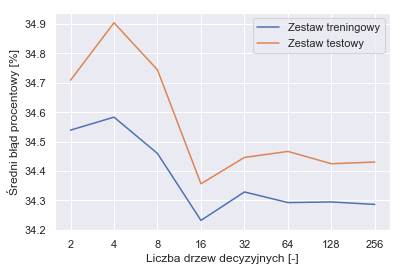

In [21]:
fig, ax = plt.subplots()
ax.plot(train_n_est, label='Zestaw treningowy')
ax.plot(test_n_est, label='Zestaw testowy')
ax.set_xticklabels([1, 2, 4, 8, 16, 32, 64, 128, 256])
ax.set_xlabel('Liczba drzew decyzyjnych [-]')
ax.set_ylabel('Średni błąd procentowy [%]')
ax.legend()
fig.savefig('n_est.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
train_n_est

In [ ]:
fig, ax = plt.subplots()
ax.plot(np.array(time_n_est) / 60)
ax.set_xticklabels([1, 1, 2, 4, 8, 16, 32, 64, 128])
ax.set_xlabel('Liczba drzew decyzyjnych [-]')
ax.set_ylabel('Czas treningu [min]')
fig.savefig('trin_time.png', dpi=300, bbox_inches='tight')
plt.show()

In [11]:
train_max_depth = []
test_max_depth = []
time_max_depth = []

In [12]:
max_depths = np.arange(1, 33)

In [13]:
for max_depth in max_depths:
    start = time.time()
    rf = RandomForestRegressor(n_estimators=100, max_depth=max_depth, n_jobs=-1)
    rf.fit(X_train, y_train)

    rf_train_pred = rf.predict(X_train)
    rf_test_pred = rf.predict(X_test) 
    
    rf_train_pred[rf_train_pred < 0] = 0
    rf_test_pred[rf_test_pred < 0] = 0
    
    rf_mape_train = mape(y_train, rf_train_pred)
    rf_mape_test= mape(y_test, rf_test_pred)
    
    train_max_depth.append(rf_mape_train)
    test_max_depth.append(rf_mape_test)
    time_max_depth.append(np.round(time.time() - start))
    print('max_depth:', max_depth, 'time:', np.round(time.time() - start))

max_depth: 1 time: 37.0
max_depth: 2 time: 70.0
max_depth: 3 time: 101.0
max_depth: 4 time: 133.0
max_depth: 5 time: 162.0
max_depth: 6 time: 195.0
max_depth: 7 time: 221.0
max_depth: 8 time: 247.0
max_depth: 9 time: 270.0
max_depth: 10 time: 296.0
max_depth: 11 time: 324.0
max_depth: 12 time: 342.0
max_depth: 13 time: 363.0
max_depth: 14 time: 387.0
max_depth: 15 time: 406.0
max_depth: 16 time: 425.0
max_depth: 17 time: 441.0
max_depth: 18 time: 457.0
max_depth: 19 time: 475.0
max_depth: 20 time: 495.0
max_depth: 21 time: 510.0
max_depth: 22 time: 558.0
max_depth: 23 time: 541.0
max_depth: 24 time: 556.0
max_depth: 25 time: 581.0
max_depth: 26 time: 603.0
max_depth: 27 time: 638.0
max_depth: 28 time: 664.0
max_depth: 29 time: 673.0
max_depth: 30 time: 744.0
max_depth: 31 time: 748.0
max_depth: 32 time: 891.0


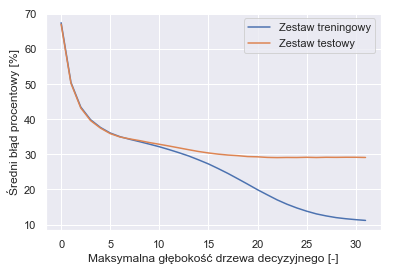

In [14]:
fig, ax = plt.subplots()
ax.plot(train_max_depth, label='Zestaw treningowy')
ax.plot(test_max_depth, label='Zestaw testowy')
#ax.set_xticklabels([1, 1, 2, 3, 4, 5, 6, 7, 8, 16, 32, 64, 100])
ax.set_xlabel('Maksymalna głębokość drzewa decyzyjnego [-]')
ax.set_ylabel('Średni błąd procentowy [%]')
ax.legend()
fig.savefig('max_depth.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
fig, ax = plt.subplots()
ax.plot(time_n_est)
plt.show()

#### random forest

In [29]:
random_tree = RandomForestRegressor(n_estimators=16, max_depth=8, n_jobs=-1)

In [30]:
start = time.time()
random_tree_fit = random_tree.fit(X_train, y_train)
print(np.round(time.time() - start))

43.0


In [31]:
random_tree_train_pred = random_tree.predict(X_train)
random_tree_test_pred = random_tree.predict(X_test)

#random_tree_train_pred = (random_tree_train_pred * sigma[-1]) + means[-1]
#random_tree_test_pred = (random_tree_test_pred * sigma[-1]) + means[-1]

#y_train = y_train * sigma[-1] +means[-1]
#y_test = y_test * sigma[-1] +means[-1]

random_tree_train_pred[random_tree_train_pred < 0] = 0
random_tree_test_pred[random_tree_test_pred < 0] = 0

In [32]:
random_tree_mape_train = mape(y_train, random_tree_train_pred)
random_tree_mape_test= mape(y_test, random_tree_test_pred)
random_tree_rmsle_train = rmsle(y_train, random_tree_train_pred)
random_tree_rmsle_test = rmsle(y_test, random_tree_test_pred)

print('RMSLE train:', random_tree_rmsle_train)
print('RMSLE test:', random_tree_rmsle_test)
print('MAPE train:', random_tree_mape_train)
print('MAPE test:', random_tree_mape_test)

RMSLE train: 0.3904810100045141
RMSLE test: 0.39145213856710515
MAPE train: 34.330752491287484
MAPE test: 34.49904439063388


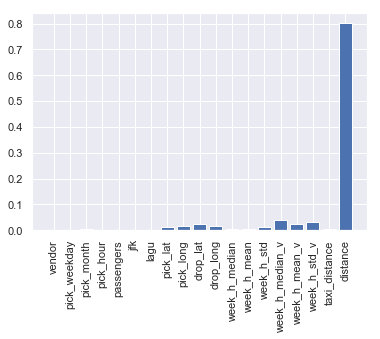

In [33]:
fig, ax = plt.subplots()
ax.bar(model.keys().values[0:-1], random_tree.feature_importances_)
ax.set_xticklabels(model.keys().values[0:-1], rotation = 90)
fig.show()

#### gradient boosting

In [ ]:
gb = GradientBoostingRegressor(n_estimators=16, max_depth=10)

In [ ]:
gb_fit = gb.fit(X_train, y_train)

In [ ]:
gb_train_pred = gb.predict(X_train)
gb_test_pred = gb.predict(X_test)

#gb_train_pred = (gb_train_pred * sigma[-1]) + means[-1]
#gb_test_pred = (gb_test_pred * sigma[-1]) + means[-1]

#y_train = y_train * sigma[-1] +means[-1]
#y_test = y_test * sigma[-1] +means[-1]

gb_train_pred[gb_train_pred < 0] = 0
gb_test_pred[gb_test_pred < 0] = 0

In [ ]:
gb_mape_train = mape(y_train, gb_train_pred)
gb_mape_test= mape(y_test, gb_test_pred)
gb_rmsle_train = rmsle(y_train, gb_train_pred)
gb_rmsle_test = rmsle(y_test, gb_test_pred)

print('RMSLE train:', gb_rmsle_train)
print('RMSLE test:', gb_rmsle_test)
print('MAPE train:', gb_mape_train)
print('MAPE test:', gb_mape_test)

RMSLE train: 0.4015084246669488<br>
RMSLE test: 0.3993211007550442<br>
MAPE train: 35.489679434699944<br>
MAPE test: 35.45410346130453


In [ ]:
model.keys().values

In [ ]:
fig, ax = plt.subplots()
ax.bar(model.keys().values[0:-1], gb.feature_importances_)
ax.set_xticklabels(model.keys().values[0:-1], rotation = 90)
fig.show()

#### xgb

In [ ]:
xgb = xgb.XGBRegressor(n_estimators=500, max_depth=12, n_jobs=-1)

In [ ]:
xgb_fit = xgb.fit(X_train, y_train)

In [ ]:
xgb_train_pred = xgb.predict(X_train)
xgb_test_pred = xgb.predict(X_test)

#xgb_train_pred = (xgb_train_pred * sigma[-1]) + means[-1]
#xgb_test_pred = (xgb_test_pred * sigma[-1]) + means[-1]

#y_train = y_train * sigma[-1] +means[-1]
#y_test = y_test * sigma[-1] +means[-1]

xgb_train_pred[xgb_train_pred < 0] = 0
xgb_test_pred[xgb_test_pred < 0] = 0

In [ ]:
xgb_mape_train = mape(y_train, xgb_train_pred)
xgb_mape_test= mape(y_test, xgb_test_pred)
xgb_rmsle_train = rmsle(y_train, xgb_train_pred)
xgb_rmsle_test = rmsle(y_test, xgb_test_pred)

print('RMSLE train:', xgb_rmsle_train)
print('RMSLE test:', xgb_rmsle_test)
print('MAPE train:', xgb_mape_train)
print('MAPE test:', xgb_mape_test)

RMSLE train: 0.40173090634003567<br>
RMSLE test: 0.40188970876794317<br>
MAPE train: 35.50541827999136<br>
MAPE test: 35.48057889440979


In [ ]:
fig, ax = plt.subplots()
ax.bar(model.keys().values[0:-1], xgb.feature_importances_)
ax.set_xticklabels(model.keys().values[0:-1], rotation = 90)
fig.show()

### knn reggresion

In [25]:
knn = KNeighborsRegressor(n_neighbors=80, n_jobs=-1)

In [26]:
knn_fit = knn.fit(X_train, y_train)

In [27]:
knn_train_pred = knn.predict(X_train)
knn_test_pred = knn.predict(X_test)

#knn_train_pred = (knn_train_pred * sigma[-1]) + means[-1]
#knn_test_pred = (knn_test_pred * sigma[-1]) + means[-1]

#y_train = y_train * sigma[-1] +means[-1]
#y_test = y_test * sigma[-1] +means[-1]

knn_train_pred[knn_train_pred < 0] = 0
knn_test_pred[knn_test_pred < 0] = 0

In [28]:
knn_mape_train = mape(y_train, knn_train_pred)
knn_mape_test= mape(y_test, knn_test_pred)
knn_rmsle_train = rmsle(y_train, knn_train_pred)
knn_rmsle_test = rmsle(y_test, knn_test_pred)

print('RMSLE train:', knn_rmsle_train)
print('RMSLE test:', knn_rmsle_test)
print('MAPE train:', knn_mape_train)
print('MAPE test:', knn_mape_test)

RMSLE train: 0.4040154559241011
RMSLE test: 0.4076574541150799
MAPE train: 35.89860480950022
MAPE test: 36.17415381623219


#### knn params search

In [22]:
train_neighbor = []
test_neighbor = []
time_neighbor = []

In [23]:
neighbors = [1] + np.arange(10, 101, 10).tolist()
for neighbor in neighbors:
    start = time.time()
    knn = KNeighborsRegressor(n_neighbors=neighbor, n_jobs=-1)
    knn.fit(X_train, y_train)

    knn_train_pred = knn.predict(X_train)
    knn_test_pred = knn.predict(X_test) 
    
    knn_train_pred[knn_train_pred < 0] = 0
    knn_test_pred[knn_test_pred < 0] = 0
    
    knn_mape_train = mape(y_train, knn_train_pred)
    knn_mape_test= mape(y_test, knn_test_pred)
    
    train_neighbor.append(knn_mape_train)
    test_neighbor.append(knn_mape_test)
    time_neighbor.append(np.round(time.time() - start))
    print('neighbor:', neighbor, 'time:', np.round(time.time() - start))

neighbor: 1 time: 16.0
neighbor: 10 time: 33.0
neighbor: 20 time: 44.0
neighbor: 30 time: 52.0
neighbor: 40 time: 59.0
neighbor: 50 time: 66.0
neighbor: 60 time: 72.0
neighbor: 70 time: 79.0
neighbor: 80 time: 85.0
neighbor: 90 time: 92.0
neighbor: 100 time: 99.0


In [ ]:
neighbors = [1] + np.arange(10, 101, 10).tolist()
neighbors

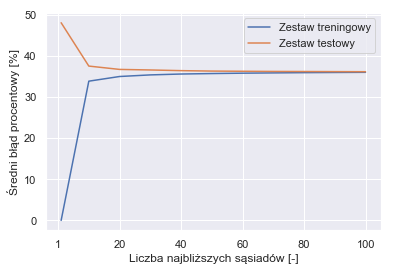

In [24]:
fig, ax = plt.subplots()
ax.plot(neighbors, train_neighbor, label='Zestaw treningowy')
ax.plot(neighbors, test_neighbor, label='Zestaw testowy')
ax.set_xticklabels([1, 1, 20, 40, 60, 80, 100, 26, 31, 36, 41, 46])
ax.set_xlabel('Liczba najbliższych sąsiadów [-]')
ax.set_ylabel('Średni błąd procentowy [%]')
ax.legend()
fig.savefig('neighbor.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
train_neighbor = train_neighbor[11:]

In [ ]:
test_neighbor = test_neighbor[11:]

#### nn

In [ ]:
nn = Sequential()
adam = Adam(lr=0.001)
nn.add(Dense(32, input_shape=x_tr.shape[1:]))
nn.add(Activation('relu'))
nn.add(Dense(32))
nn.add(Activation('relu'))
nn.add(Dense(32))
nn.add(Activation('relu'))
nn.add(Dense(1))
nn.add(Activation('sigmoid'))
nn.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
nn.fit(x_tr, y_tr, batch_size=32, epochs=5)
nn_pred_tr = nn.predict(x_tr)
nn_pred_te = nn.predict(x_te)
print('Accuracy on train set: ', accuracy_score(nn_pred_tr > 0.5, y_tr))
print('Accuracy on test set: ', accuracy_score(nn_pred_te > 0.5, y_te))
print('\n Report on train set:')
print(classification_report(y_tr, nn_pred_tr > 0.5))
print('\n Report on test set:')
print(classification_report(y_te, nn_pred_te > 0.5))

#### Vendor, a pc

In [ ]:
vendor_1 = dataset4['passengers'][dataset4['vendor'] == 1]
vendor_2 = dataset4['passengers'][dataset4['vendor'] == 2]
fig_10, ax_10 = plt.subplots()
ax_10.scatter(vendor_1.unique(), vendor_1.value_counts(), marker='x')
ax_10.scatter(vendor_2.unique(), vendor_2.value_counts())
plt.show()
print('Vendor_1:\n', vendor_1.value_counts())
print('Vendor_2:\n', vendor_2.value_counts())

#### Vendor a store and flag

In [ ]:
vendor_1 = dataset4['flag'][dataset4['vendor'] == 1]
vendor_2 = dataset4['flag'][dataset4['vendor'] == 2]
fig_10, ax_10 = plt.subplots()
ax_10.scatter(vendor_1.unique(), vendor_1.value_counts(), marker='x')
ax_10.scatter(vendor_2.unique(), vendor_2.value_counts())
plt.show()
print('Vendor_1:\n', vendor_1.value_counts())
print('Vendor_2:\n', vendor_2.value_counts())

In [ ]:
dataset4['pick_month'].unique()

In [ ]:
ax1 = sns.distplot(np.log(dataset3['speed'] + 0.000000000000000001))

In [ ]:
ax2 = sns.distplot(np.log(dataset3['dist'] + 0.000000000000000001))

### Detekcja outliers / błędów w danych

#### Sprawdzenie czy p i d datetime pokrywa się z trip_duration

In [ ]:
diffs = dataset3['dd'] - dataset3['pd']
diffs_s = pd.Series([diff.seconds + 86400 * diff.days for diff in diffs])

In [ ]:
u, c = np.unique(dataset3['td'].values == diffs_s.values, return_counts=True)
print(u, c)

#### Zerowy dystans

In [ ]:
uniq_d, c_d = np.unique(dataset3['dist'] == 0, return_counts=True)
print(uniq_d)
print(c_d)

* 6125 podróży z zerowym dystansem - usuwamy

#### Zerowa prędkość

In [ ]:
uniq_v, c_v = np.unique(dataset3['speed'] == 0, return_counts=True)
print(uniq_v)
print(c_v)

#### Bardzo długie i bardzo krótkie podróże

In [ ]:
def trip_time(time_s):
    h = time_s // 3600
    m = (time_s - 3600 * h) // 60
    s = time_s - 3600 * h - 60 * m
    print(f'Trip time: {h}h {m}m {s}s')

In [ ]:
for time in dataset3['td'].nlargest(n=5):
    trip_time(time)
    
for time in dataset3['td'].nsmallest(n=5):
    trip_time(time)

#### 4 najdłuższe

In [ ]:
longest = dataset3['td'].nlargest(n=4)
n_longest = [int(index) for index in longest.index]
display(dataset3.iloc[n_longest])

* pdróże po kilka dni, nie realistyczne prędkości - usuówamy

In [ ]:
def trip_map(dataset, trip_index):
    x_p = dataset['pick_long'].values[trip_index]
    y_p = dataset['pick_lat'].values[trip_index]
    x_d = dataset['drop_long'].values[trip_index]
    y_d = dataset['drop_lat'].values[trip_index]

    fig, ax = plt.subplots()
    ax.scatter(x_p, y_p, s=100, color='r', marker='o', label='pickup')
    ax.scatter(x_d, y_d, s=100, color='black', marker='o', label='dropoff')
    return mpll.display(fig=fig)

In [ ]:
trip_map(dataset4, 978383)
trip_map(dataset4, 978384)

In [ ]:
print(distances.shape)
display(distances[0:10])

In [ ]:
same_lat = (dataset3['plat'] == dataset3['dlat']).values
same_long = (dataset3['plong'] == dataset3['dlong']).values
np.unique(np.logical_and(same_lat, same_long), return_counts=True)

In [ ]:
t = np.array([True, True, False])
f = np.array([True, False, False])
np.logical_and(t, f)

In [ ]:
np.unique(distances == 0, return_counts=True)

In [ ]:
sns.distplot(np.log(dataset3['dist']))

In [ ]:
display(dataset3.head(n=2))

In [ ]:
max_ind = dataset['trip_duration'][dataset['trip_duration'] == max_trip]
min_ind = dataset['trip_duration'][dataset['trip_duration'] == min_trip]

In [ ]:
ax = sns.countplot(x='vid', data=dataset)

In [ ]:
ax = sns.countplot(x='passenger_count', data=dataset)

In [ ]:
ax = sns.distplot(np.log(dataset['trip_duration']))

In [ ]:
print('Najdłuższy czas podróży:', dataset['trip_duration'].max() / 3600, 'godz.')
print('Najkrótszy czas podróży:', dataset['trip_duration'].min(), 's.')

In [ ]:
dataset['pickup_datetime'][1]

In [ ]:
# datetime.date.weekday() - Monday is 0
test = pd.to_datetime(dataset['pickup_datetime'])
weekdays = []
for d in test:
    y = d.date().weekday()
    weekdays.append(y)
weekdays = pd.Series(weekdays)

In [ ]:
dataset2 = dataset.copy()
dataset2.insert(loc=4, column='week_day', value=weekdays)

In [ ]:
display(dataset2.head())

In [ ]:
ax = sns.countplot(x='week_day', data=dataset2)


In [ ]:
pick_datetime = pd.to_datetime(dataset2['pickup_datetime'])
drop_datetime = pd.to_datetime(dataset2['dropoff_datetime'])

In [ ]:
print(pick_datetime.dtype)
print(drop_datetime.dtype)
print(dataset2['pickup_datetime'].dtype)
print(dataset2['dropoff_datetime'].dtype)

In [ ]:
dataset2 = dataset2.drop(labels=['pickup_datetime', 'dropoff_datetime'], axis=1)

In [ ]:
dataset2.head()

In [ ]:
dataset2.insert(loc=3, column='pickup_datetime', value=pick_datetime)
dataset2.insert(loc=4, column='dropoff_datetime', value=drop_datetime)

In [ ]:
display(dataset2.head())
print(dataset2['pickup_datetime'].dtype)

In [ ]:
# datetime.date.weekday() - Monday is 0
test = pd.to_datetime(dataset['pickup_datetime'])
weekdays = []
days = []
months = []
hours = []
minutes = []
seconds = []

for d in test:
    hour = d.time().hour
    minute = d.time().minute
    second = d.time().second
    weekday = d.date().weekday()
    day = d.date().day
    month = d.date().month
    weekdays.append(weekday)
    days.append(day)
    months.append(month)
    hours.append(hour)
    minutes.append(minute)
    seconds.append(second)
weekdays = pd.Series(weekdays)
days = pd.Series(days)
months = pd.Series(months)
hours = pd.Series(hours)
minutes = pd.Series(minutes)
seconds = pd.Series(seconds)

In [ ]:
dataset2 = dataset.copy()
dataset2.insert(loc=4, column='week_day', value=weekdays)
dataset2.insert(loc=5, column='month', value=months)
dataset2.insert(loc=6, column='day', value=days)
dataset2.insert(loc=7, column='hour', value=hours)
dataset2.insert(loc=8, column='minute', value=minutes)
dataset2.insert(loc=9, column='second', value=seconds)

In [ ]:
display(dataset2.head())

In [ ]:
dataset3 = dataset2.drop(labels=['id', 'pickup_datetime', 'dropoff_datetime', 'store_and_fwd_flag'], axis=1)

In [ ]:
dataset3.head()

In [ ]:
X = dataset3.values

In [ ]:
XX = train_test_split(X, test_size=0.2)

In [ ]:
print(XX[0].shape)
print(XX[1].shape)

In [ ]:
X_train = XX[0][:, 0:12]
X_test = XX[1][:, 0:12]
y_train = XX[0][:, 12]
y_test = XX[1][:, 12]

In [ ]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

In [ ]:
linreg = LinearRegression()

In [ ]:
linreg.fit(X_train, y_train)

In [ ]:
print(linreg.score(X_train, y_train))
print(linreg.score(X_test, y_test))

In [ ]:
linreg_train = linreg.predict(X_train)
linreg_test = linreg.predict(X_test)

In [ ]:
MSE_tr = mean_squared_error(y_train, linreg_train)
MSE_te = mean_squared_error(y_test, linreg_test)

In [ ]:
print(MSE_tr)
print(MSE_te)

In [ ]:
coords_1 = (52.2296756, 21.0122287)
coords_2 = (52.406374, 16.9251681)

print(geopy.distance.vincenty(coords_1, coords_2).m)

In [ ]:
dataset3.head()

In [ ]:
coords_1 = [40.767937, -73.982155]
coords_2 = [40.765602, -73.964630]

print(geopy.distance.vincenty(coords_1, coords_2).m)

In [ ]:
print(coords_1)

In [ ]:
dataset3val = dataset3.values


In [ ]:
time.localtime().tm_min
distances = []
for i in range(dataset3val.shape[0]):
    dataset2.values[i, 8]  
    p_lat = p_long = dataset2.values[i, 9]
    p_long = dataset2.values[i, 8] 
    d_lat = dataset2.values[i, 11]
    d_long = dataset2['dropoff_longitude'][10]
    coords_1 = [p_lat, p_long]
    coords_2 = [d_lat, d_long]
    distances.append(geopy.distance.distance(coords_1, coords_2).m)
    if i % 1000 == 0:
        print(i)
        print(time.localtime().tm_min)   

#### Średnia prędkość

In [ ]:
avg_speed = (distances / 1000) / (dataset3['td'].values / 3600)

In [ ]:
dataset3.insert(loc=11, column='dist', value=distances)
dataset3.insert(loc=12, column='speed', value=avg_speed)

In [ ]:
display(dataset3.head(n=2))

In [ ]:
fig = plt.figure()
fig.figsize=(10, 12)

In [ ]:
def visualise_trip(dataset, trips):
    
    fig = plt.figure(figsize=(12,10))
    ax = fig.add_subplot(1, 1, 1, xlabel='longitude [°]', ylabel='longitude [°]')
    #fig.figsize=(15, 10)
    image = plt.imread('nyc.jpg')
    ax.imshow(image, extend=[-69, -71, 39, 41])
    #ax = nyc.plot(alpha=0.5)
    ax.scatter(dataset['plong'][trips], dataset['plat'][trips], s=20, c='r', label='pickup')
    ax.scatter(dataset['dlong'][trips], dataset['dlat'][trips], s=20, c='b', label='dropoff')
    ax.plot((dataset['plong'][trips], dataset['dlong'][trips]),
            (dataset['plat'][trips], dataset['dlat'][trips]), c='black', linewidth=1)
    ax.legend(loc='upper left')
    ax.grid(False)
    
    #ax.xlabel = 'longitude \[°\]'
    #plt.legend(loc = 'upper left')
    #plt.show()
    #ax.plot(x_d, y_d, 'ro')
    #mpll.display(fig=fig)

In [ ]:
nyc = gpd.read_file(gpd.datasets.get_path('nybb'))
nyc.crs['x_0'] = 180
nyc.plot(figsize=(24, 20), alpha=0.5)
plt.grid(False)
plt.savefig('nyc.jpg')

In [ ]:
poly = nyc.iloc[[3]]['geometry']
type(poly)

In [ ]:
image = plt.imread('nyc.jpg')
fig, ax = plt.subplots()
x = range(300)
ax.imshow(image, extent=[0, 400, 0, 300])
ax.scatter(dataset3['plong'][0:100], dataset3['plat'][0:100], s=10, c='r')

In [ ]:
jfk = (dataset5['drop_lat'] < 40.675561) & (dataset5['drop_lat'] > 40.624477) & (dataset5['drop_long'] < -73.749772) & (dataset5['drop_long'] > -73.838634)
dataset5[jfk]

In [ ]:
fig, ax = plt.subplots()
ax.scatter([-73.828634, -73.749772], [40.624477, 40.675561])
plt.show()

In [ ]:
trips = [1, 2, 3]
print(dataset3['td'][trips])

In [ ]:
fig, ax = plt.subplots()
ax.plot([40.738564, -73.980415], [40.731152, -70.999481], 'or-')
mpll.display(fig=fig)